In [1]:
from sqlalchemy import create_engine
import pandas as pd
from sqlalchemy import Table, Column, Integer, String, ForeignKey, MetaData
from sqlalchemy.orm import declarative_base, relationship, Session, sessionmaker
import pymysql
import numpy as np
import ast
import os
from sqlalchemy import select
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from plotly.subplots import make_subplots
import plotly.express as px

username = 'root'
password = '9763sanA!'
host = 'localhost'   
port = 3306             
database = 'nba'

engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}', connect_args={'connect_timeout': 60})
metadata = MetaData()
Base = declarative_base()
session = Session(engine)

In [2]:
class Player(Base):
    __tablename__ = 'players'
    id = Column(String(64), primary_key= True)
    name = Column(String(64), unique= True)
    weight = Column(Integer)
    height = Column(Integer)
    exp = Column(Integer)
    age = Column(Integer)
    
    fact = relationship('Fact', back_populates='player')
    player_position = relationship('PlayerPosition', back_populates='player')
    team = relationship('PlayerTeam',back_populates='player')

In [3]:
class Season(Base):
    __tablename__ ='seasons'
    id = Column(Integer,primary_key=True,autoincrement=True)
    season = Column(Integer,unique=True)
    fact = relationship('Fact',back_populates='season')

In [4]:
class PlayerGroup(Base):
    __tablename__ ='player_group'
    id = Column(Integer,primary_key=True,autoincrement=True)
    player_group = Column(String(64),unique=True)
    fact = relationship('Fact',back_populates='player_group')

In [5]:
class Position(Base):
    __tablename__ ='position'
    id = Column(Integer,primary_key=True,autoincrement=True)
    position = Column(String(64),unique=True)
    player_position = relationship('PlayerPosition',back_populates='position')

In [6]:
class Fact(Base):
    __tablename__ ='fact'
    id = Column(Integer,primary_key=True)
    player_id = Column(String(64),ForeignKey('players.id'))
    season_id = Column(Integer, ForeignKey('seasons.id'))
    group_id = Column(Integer, ForeignKey('player_group.id'))
    rank = Column(Integer)
    points = Column(Integer)
    
    player = relationship('Player',back_populates='fact')
    season = relationship('Season',back_populates='fact')
    player_group = relationship('PlayerGroup',back_populates='fact')

In [7]:
class PlayerPosition(Base):
    __tablename__ ='player_position'
    id = Column(Integer,primary_key=True,autoincrement=True)
    player_id = Column(String(64),ForeignKey('players.id'))
    position_id = Column(Integer,ForeignKey('position.id'))
    player = relationship('Player',back_populates='player_position')
    position = relationship('Position',back_populates='player_position')

In [8]:
class Team(Base):
    __tablename__='team'
    id = Column(Integer,primary_key=True,autoincrement=True) 
    team_name = Column(String(64), unique= True)
    players = relationship('PlayerTeam',back_populates='team')

In [9]:
class PlayerTeam(Base):
    __tablename__='player_team'
    id = Column(Integer,primary_key=True)
    team_id = Column(Integer,ForeignKey('team.id'))
    player_id = Column(String(64),ForeignKey('players.id'))
    player = relationship('Player',back_populates='team')
    team = relationship('Team',back_populates='players')

In [10]:
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)

In [11]:
DATA_DIR = r'G:\Data Analysis\mini project 3\CSV files'

CSV_FILES = {
    'players':         os.path.join(DATA_DIR, 'player.csv'),
    'seasons':         os.path.join(DATA_DIR, 'seasons.csv'),
    'player_group':    os.path.join(DATA_DIR, 'player_group.csv'),
    'position':        os.path.join(DATA_DIR, 'position.csv'),
    'player_position': os.path.join(DATA_DIR, 'player_position.csv'),
    'fact':            os.path.join(DATA_DIR, 'fact.csv'),
}

load_order = [
    'players', 'seasons', 'player_group', 'position', 'player_position', 'fact']

for t in load_order:
    path = CSV_FILES.get(t)
    if not path or not os.path.exists(path):
        print(f'[SKIP] {t}: csv not found')
        continue

    df = pd.read_csv(path)
    df = df.loc[:, ~df.columns.str.lower().str.startswith('unnamed')]

    if 'id' in df.columns and df['id'].isna().all():
        df = df.drop(columns=['id'])

    df.to_sql(t, con=engine, if_exists='append', index=False, chunksize=5000, method='multi')
    print(f'[OK] loaded {len(df)} rows into {t}')

[OK] loaded 165 rows into players
[OK] loaded 7 rows into seasons
[OK] loaded 3 rows into player_group
[OK] loaded 5 rows into position
[OK] loaded 273 rows into player_position
[OK] loaded 350 rows into fact


In [12]:
df_players = pd.read_sql_table('players', con=engine)
df_players.head()

,id,name,weight,height,exp,age
0,adamsja01,Jaylen Adams,102,183,3,24
1,antetgi01,Giannis Antetokounmpo,109,211,12,30
2,antetko01,Kostas Antetokounmpo,90,208,3,22
3,antetth01,Thanasis Antetokounmpo,99,201,6,28
4,augusdj01,D.J. Augustin,83,180,14,33


In [13]:
df_players = pd.read_sql_table('seasons', con=engine)
df_players.head()

,id,season
0,1,2019
1,2,2020
2,3,2021
3,4,2022
4,5,2023


In [14]:
df_players = pd.read_sql_table('player_group', con=engine)
df_players.head()

,id,player_group
0,3,League Champion
1,2,MVP
2,1,Total Stat


In [15]:
df_players = pd.read_sql_table('position', con=engine)
df_players.head()

,id,position
0,3,Center
1,1,Point Guard
2,4,Power Forward
3,2,Shooting Guard
4,5,Small Forward


In [16]:
df_players = pd.read_sql_table('player_position', con=engine)
df_players.head()

,id,player_id,position_id
0,1,gilgesh01,1
1,2,gilgesh01,2
2,3,edwaran01,2
3,4,jokicni01,3
4,5,antetgi01,4


In [17]:
df_players = pd.read_sql_table('fact', con=engine)
df_players.head()

,id,player_id,season_id,group_id,rank,points
0,1,gilgesh01,7,1,1.0,2484.0
1,2,edwaran01,7,1,2.0,2177.0
2,3,jokicni01,7,1,3.0,2071.0
3,4,antetgi01,7,1,4.0,2036.0
4,5,tatumja01,7,1,5.0,1932.0


In [18]:
with Session(engine) as s:
    stmt = (
        select(
            Player.id.label('player_id'),
            Player.name,
            Player.age,
            Player.height,
            Player.weight,
            Player.exp,
            Season.season,
            PlayerGroup.player_group,
            # Position.position,
            Fact.rank,
            Fact.points
        )
        .join(Fact, Fact.player_id == Player.id)
        .join(Season, Season.id == Fact.season_id)
        .join(PlayerGroup, PlayerGroup.id == Fact.group_id)
        # .join(PlayerPosition, PlayerPosition.player_id == Player.id)
        # .join(Position, Position.id == PlayerPosition.position_id)
    )

    result = s.execute(stmt)

    df_all = pd.DataFrame(result.fetchall(), columns=result.keys())

df_all.head()

,player_id,name,age,height,weight,exp,season,player_group,rank,points
0,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2025,League Champion,NaN,NaN
1,willija06,Jalen Williams,23,198,99,3,2025,League Champion,NaN,NaN
2,dortlu01,Luguentz Dort,25,193,99,6,2025,League Champion,NaN,NaN
3,harteis01,Isaiah Hartenstein,26,213,115,7,2025,League Champion,NaN,NaN
4,wallaca01,Cason Wallace,21,193,92,2,2025,League Champion,NaN,NaN


In [19]:
df_all.shape

(350, 10)

# Descriptive statistics

## Height Distribution of Michael Jordan Trophy and Top 50 Players

In [20]:
mjt_players = df_all[df_all['player_group'] == 'MVP']
mjt_players

,player_id,name,age,height,weight,exp,season,player_group,rank,points
115,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2025,MVP,1.0,NaN
116,jokicni01,Nikola Jokić,29,211,128,10,2025,MVP,2.0,NaN
117,antetgi01,Giannis Antetokounmpo,30,211,109,12,2025,MVP,3.0,NaN
118,tatumja01,Jayson Tatum,26,203,95,8,2025,MVP,4.0,NaN
119,mitchdo01,Donovan Mitchell,28,190,97,8,2025,MVP,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...
195,duranke01,Kevin Durant,36,211,108,17,2019,MVP,8.0,NaN
196,leonaka01,Kawhi Leonard,32,201,102,13,2019,MVP,9.0,NaN
197,westbru01,Russell Westbrook,33,193,90,17,2019,MVP,10.0,NaN
198,goberru01,Rudy Gobert,28,216,117,12,2019,MVP,11.0,NaN


In [21]:
ts_players = df_all[df_all['player_group'] == 'Total Stat']
ts_players_five_season = ts_players[(ts_players['season'] >= 2019) & (ts_players['season'] <= 2024)]
ts_players_top_50 = ts_players_five_season.sort_values(by='points', ascending=False).head(50)
ts_players_top_50

,player_id,name,age,height,weight,exp,season,player_group,rank,points
225,doncilu01,Luka Dončić,24,198,104,7,2024,Total Stat,1.0,2370.0
325,hardeja01,James Harden,35,196,99,16,2020,Total Stat,1.0,2335.0
226,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2024,Total Stat,2.0,2254.0
250,tatumja01,Jayson Tatum,26,203,95,8,2023,Total Stat,1.0,2225.0
227,antetgi01,Giannis Antetokounmpo,30,211,109,12,2024,Total Stat,3.0,2222.0
228,brunsja01,Jalen Brunson,28,188,86,7,2024,Total Stat,4.0,2212.0
251,embiijo01,Joel Embiid,28,213,127,9,2023,Total Stat,2.0,2183.0
275,youngtr01,Trae Young,26,185,74,7,2022,Total Stat,1.0,2155.0
252,doncilu01,Luka Dončić,24,198,104,7,2023,Total Stat,3.0,2138.0
253,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2023,Total Stat,4.0,2135.0


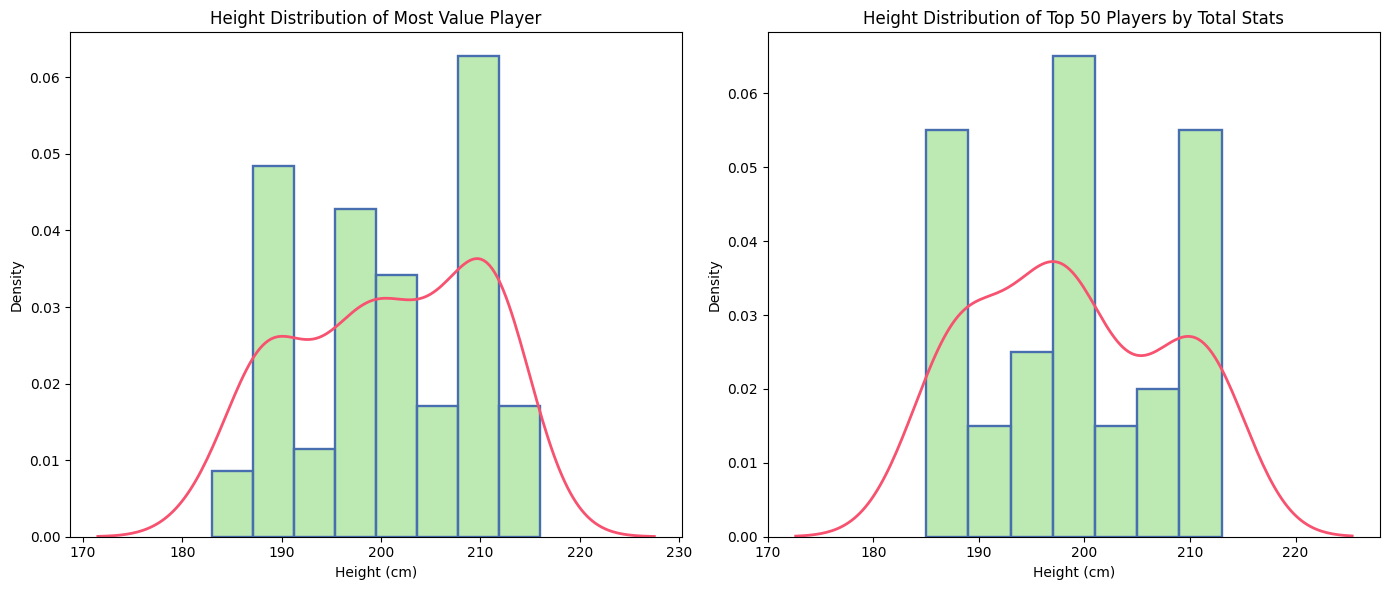

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    mjt_players['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0]
)
sns.kdeplot(
    mjt_players['height'],
    color='#F75270',
    lw=2,
    ax=axes[0]
)
axes[0].set_title('Height Distribution of Most Value Player')
axes[0].set_xlabel('Height (cm)')
axes[0].set_ylabel('Density')

sns.histplot(
    ts_players_top_50['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1]
)
sns.kdeplot(
    ts_players_top_50['height'],
    color='#F75270',
    lw=2,   
    ax=axes[1]
)
axes[1].set_title('Height Distribution of Top 50 Players by Total Stats')
axes[1].set_xlabel('Height (cm)')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

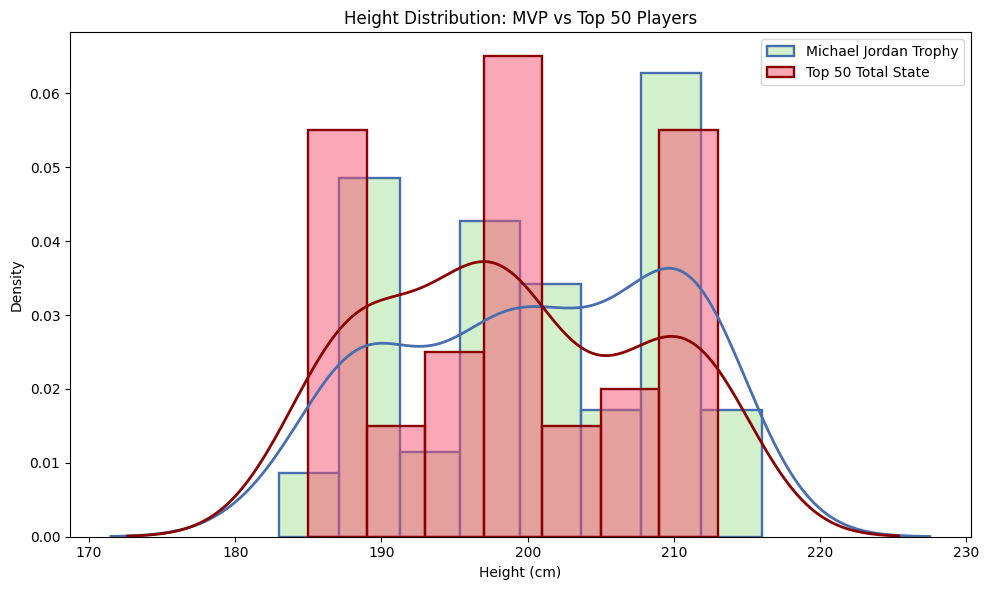

In [23]:
plt.figure(figsize=(10, 6))

sns.histplot(
    mjt_players['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Michael Jordan Trophy'
)
sns.kdeplot(
    mjt_players['height'],
    color='#476EAE',
    lw=2
)

sns.histplot(
    ts_players_top_50['height'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Top 50 Total State'
)
sns.kdeplot(
    ts_players_top_50['height'],
    color='#8B0000',
    lw=2
)

plt.title('Height Distribution: MVP vs Top 50 Players')
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
height_mjt = mjt_players['height'].describe()
height_mjt

count     85.000000
mean     200.741176
std        9.323745
min      183.000000
25%      193.000000
50%      201.000000
75%      211.000000
max      216.000000
Name: height, dtype: float64

In [25]:
height_ts = ts_players_top_50['height'].describe()
height_ts

count     50.000000
mean     198.760000
std        9.015995
min      185.000000
25%      190.000000
50%      198.000000
75%      207.500000
max      213.000000
Name: height, dtype: float64

## Experience and Height Distribution of Champion Team and Top 15 Players

### 2024-2025

In [26]:
lc_players = df_all[df_all['player_group'] == 'League Champion']
lc_players_2024_2025 = lc_players[lc_players['season'] >= 2024]
lc_players_2024_2025

,player_id,name,age,height,weight,exp,season,player_group,rank,points
0,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2025,League Champion,NaN,NaN
1,willija06,Jalen Williams,23,198,99,3,2025,League Champion,NaN,NaN
2,dortlu01,Luguentz Dort,25,193,99,6,2025,League Champion,NaN,NaN
3,harteis01,Isaiah Hartenstein,26,213,115,7,2025,League Champion,NaN,NaN
4,wallaca01,Cason Wallace,21,193,92,2,2025,League Champion,NaN,NaN
5,holmgch01,Chet Holmgren,22,216,96,2,2025,League Champion,NaN,NaN
6,wiggiaa01,Aaron Wiggins,26,198,90,4,2025,League Champion,NaN,NaN
7,joeis01,Isaiah Joe,25,196,82,5,2025,League Champion,NaN,NaN
8,carusal01,Alex Caruso,30,196,84,8,2025,League Champion,NaN,NaN
9,willija07,Jaylin Williams,22,203,113,3,2025,League Champion,NaN,NaN


In [27]:
ts_players_2024_2025 = ts_players[ts_players['season'] >= 2024]
ts_players_top_15_2024_2025 = ts_players_2024_2025.sort_values(by='points', ascending=False).head(15)
ts_players_top_15_2024_2025

,player_id,name,age,height,weight,exp,season,player_group,rank,points
200,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2025,Total Stat,1.0,2484.0
225,doncilu01,Luka Dončić,24,198,104,7,2024,Total Stat,1.0,2370.0
226,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2024,Total Stat,2.0,2254.0
227,antetgi01,Giannis Antetokounmpo,30,211,109,12,2024,Total Stat,3.0,2222.0
228,brunsja01,Jalen Brunson,28,188,86,7,2024,Total Stat,4.0,2212.0
201,edwaran01,Anthony Edwards,23,193,102,5,2025,Total Stat,2.0,2177.0
229,jokicni01,Nikola Jokić,29,211,128,10,2024,Total Stat,5.0,2085.0
202,jokicni01,Nikola Jokić,29,211,128,10,2025,Total Stat,3.0,2071.0
230,edwaran01,Anthony Edwards,23,193,102,5,2024,Total Stat,6.0,2049.0
203,antetgi01,Giannis Antetokounmpo,30,211,109,12,2025,Total Stat,4.0,2036.0


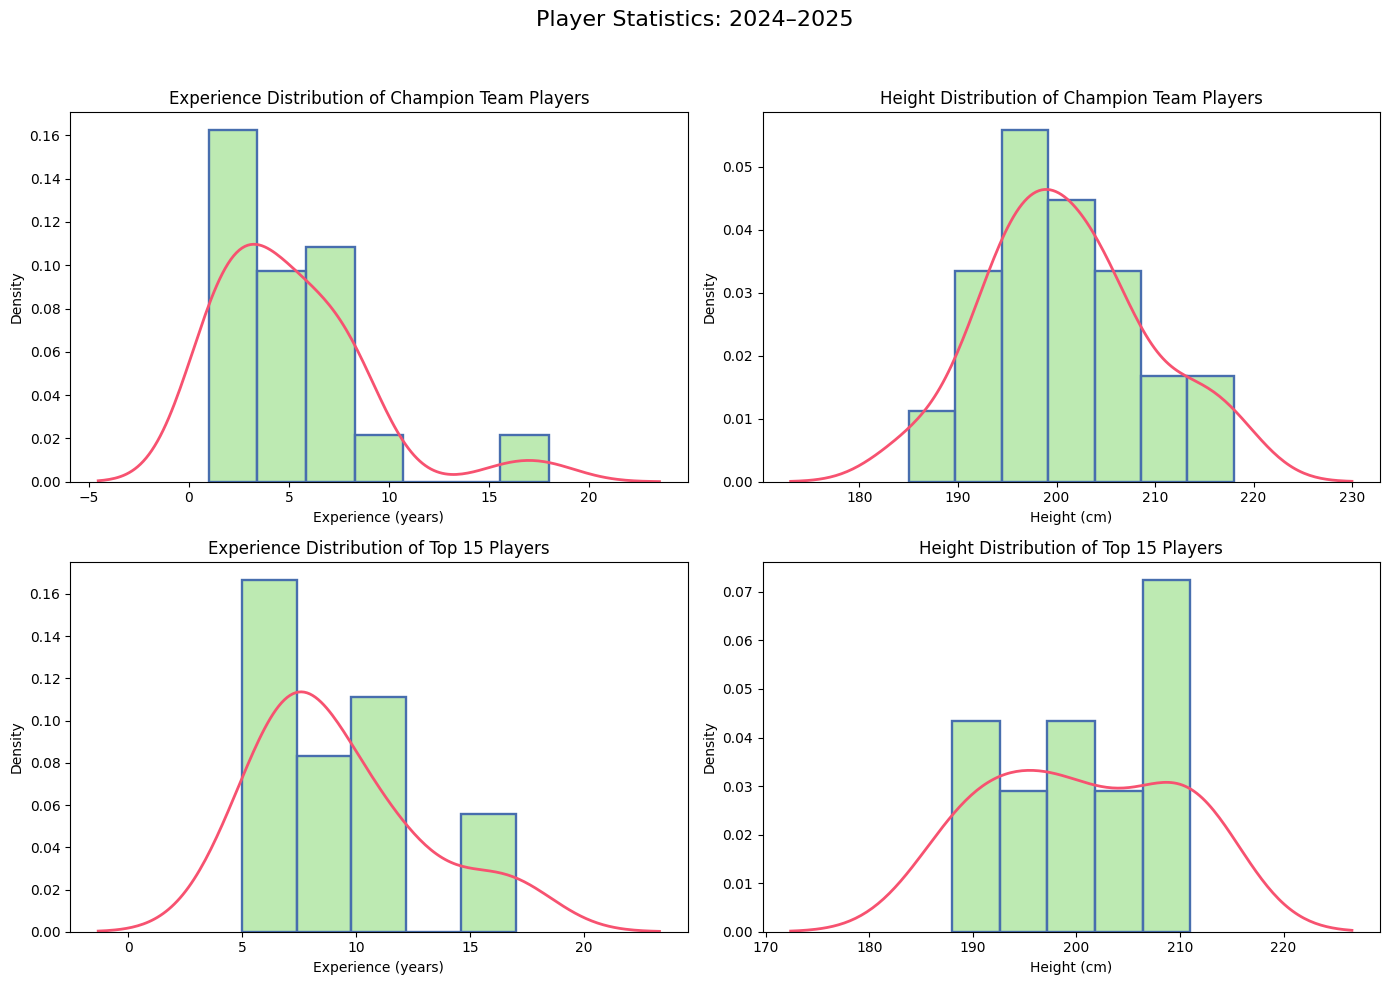

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Experience - Champion Team
sns.histplot(
    lc_players_2024_2025['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0,0]
)
sns.kdeplot(
    lc_players_2024_2025['exp'],
    color='#F75270',
    lw=2,
    ax=axes[0,0]
)
axes[0,0].set_title('Experience Distribution of Champion Team Players')
axes[0,0].set_xlabel('Experience (years)')
axes[0,0].set_ylabel('Density')

# Height - Champion Team
sns.histplot(
    lc_players_2024_2025['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0,1]
)
sns.kdeplot(
    lc_players_2024_2025['height'],
    color='#F75270',
    lw=2,
    ax=axes[0,1]
)
axes[0,1].set_title('Height Distribution of Champion Team Players')
axes[0,1].set_xlabel('Height (cm)')
axes[0,1].set_ylabel('Density')

# Experience - Top 15 Players
sns.histplot(
    ts_players_top_15_2024_2025['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1,0]
)
sns.kdeplot(
    ts_players_top_15_2024_2025['exp'],
    color='#F75270',
    lw=2,
    ax=axes[1,0]
)
axes[1,0].set_title('Experience Distribution of Top 15 Players')
axes[1,0].set_xlabel('Experience (years)')
axes[1,0].set_ylabel('Density')

# Height - Top 15 Players
sns.histplot(
    ts_players_top_15_2024_2025['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1,1]
)
sns.kdeplot(
    ts_players_top_15_2024_2025['height'],
    color='#F75270',
    lw=2,
    ax=axes[1,1]
)
axes[1,1].set_title('Height Distribution of Top 15 Players')
axes[1,1].set_xlabel('Height (cm)')
axes[1,1].set_ylabel('Density')

fig.suptitle('Player Statistics: 2024–2025', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

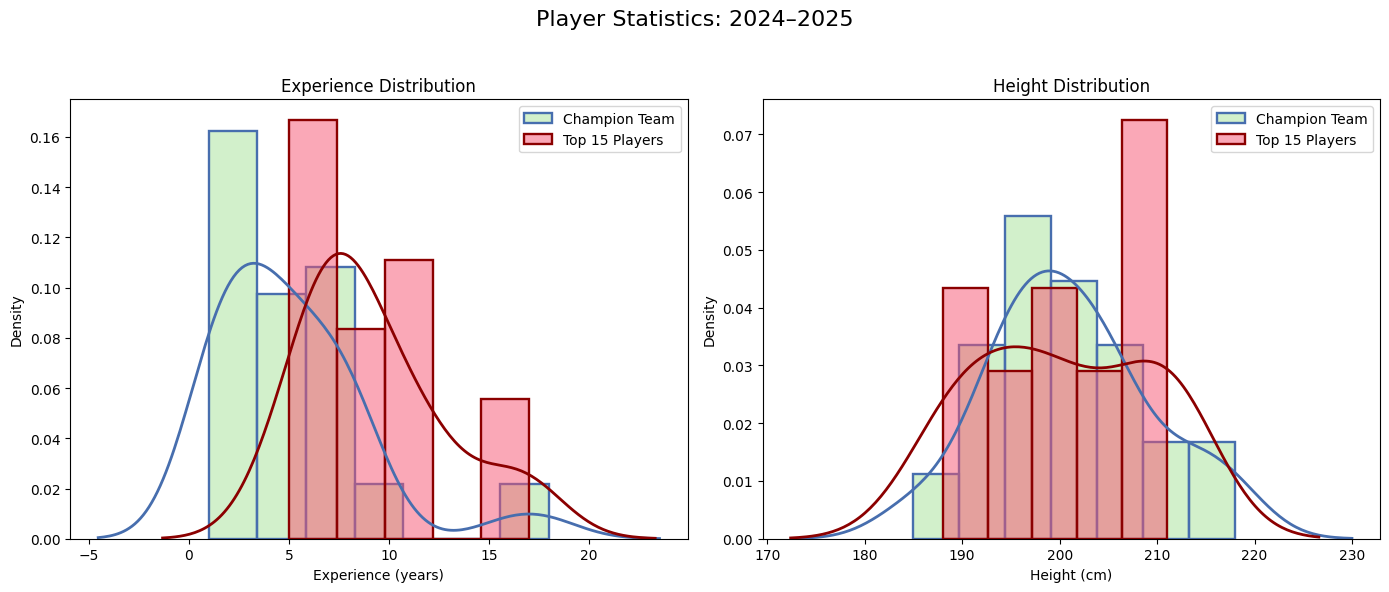

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    lc_players_2024_2025['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0],
    alpha=0.5,
    label='Champion Team'
)
sns.kdeplot(
    lc_players_2024_2025['exp'], 
    color='#476EAE', 
    lw=2, 
    ax=axes[0]
)
sns.histplot(
    ts_players_top_15_2024_2025['exp'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    ax=axes[0],
    alpha=0.5,
    label='Top 15 Players',
)
sns.kdeplot(
    ts_players_top_15_2024_2025['exp'], 
    color='#8B0000', 
    lw=2, 
    ax=axes[0]
)
axes[0].set_title('Experience Distribution')
axes[0].set_xlabel('Experience (years)')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.histplot(
    lc_players_2024_2025['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1],
    alpha=0.5,
    label='Champion Team',
)
sns.kdeplot(
    lc_players_2024_2025['height'], 
    color='#476EAE', 
    lw=2, 
    ax=axes[1]
)
sns.histplot(
    ts_players_top_15_2024_2025['height'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    ax=axes[1],
    alpha=0.5,
label='Top 15 Players'
)
sns.kdeplot(
    ts_players_top_15_2024_2025['height'], 
    color='#8B0000', 
    lw=2, 
    ax=axes[1]
)

axes[1].set_title('Height Distribution')
axes[1].set_xlabel('Height (cm)')
axes[1].set_ylabel('Density')
axes[1].legend()

fig.suptitle('Player Statistics: 2024–2025', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [30]:
eh_lc_players_24_25 = lc_players_2024_2025[['exp', 'height']].describe()
eh_lc_players_24_25

,exp,height
count,38.000000,38.000000
mean,5.052632,201.105263
std,3.812833,8.271702
min,1.000000,185.000000
25%,2.000000,196.000000
50%,4.000000,201.000000
75%,7.000000,206.000000
max,18.000000,218.000000


In [31]:
eh_ts_players_24_25 = ts_players_top_15_2024_2025[['exp', 'height']].describe()
eh_ts_players_24_25

,exp,height
count,15.000000,15.000000
mean,9.266667,200.466667
std,3.614784,8.935217
min,5.000000,188.000000
25%,7.000000,193.000000
50%,8.000000,198.000000
75%,11.000000,211.000000
max,17.000000,211.000000


### 2024

In [32]:
lc_players_2024 = lc_players[lc_players['season'] == 2024]
lc_players_2024

,player_id,name,age,height,weight,exp,season,player_group,rank,points
19,tatumja01,Jayson Tatum,26,203,95,8,2024,League Champion,NaN,NaN
20,brownja02,Jaylen Brown,27,198,101,9,2024,League Champion,NaN,NaN
21,holidjr01,Jrue Holiday,33,193,92,16,2024,League Champion,NaN,NaN
22,whitede01,Derrick White,29,193,86,8,2024,League Champion,NaN,NaN
23,porzikr01,Kristaps Porziņģis,28,218,108,9,2024,League Champion,NaN,NaN
24,horfoal01,Al Horford,37,206,108,18,2024,League Champion,NaN,NaN
25,pritcpa01,Payton Pritchard,26,185,88,5,2024,League Champion,NaN,NaN
26,hausesa01,Sam Hauser,26,203,97,4,2024,League Champion,NaN,NaN
27,kornelu01,Luke Kornet,28,218,113,8,2024,League Champion,NaN,NaN
28,tillmxa01,Xavier Tillman Sr.,25,203,111,5,2024,League Champion,NaN,NaN


In [33]:
ts_players_2024 = ts_players[ts_players['season'] == 2024]
ts_players_top_15_2024 = ts_players_2024.sort_values(by='points', ascending=False).head(15)
ts_players_top_15_2024

,player_id,name,age,height,weight,exp,season,player_group,rank,points
225,doncilu01,Luka Dončić,24,198,104,7,2024,Total Stat,1.0,2370.0
226,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2024,Total Stat,2.0,2254.0
227,antetgi01,Giannis Antetokounmpo,30,211,109,12,2024,Total Stat,3.0,2222.0
228,brunsja01,Jalen Brunson,28,188,86,7,2024,Total Stat,4.0,2212.0
229,jokicni01,Nikola Jokić,29,211,128,10,2024,Total Stat,5.0,2085.0
230,edwaran01,Anthony Edwards,23,193,102,5,2024,Total Stat,6.0,2049.0
231,duranke01,Kevin Durant,36,211,108,17,2024,Total Stat,7.0,2032.0
232,tatumja01,Jayson Tatum,26,203,95,8,2024,Total Stat,8.0,1987.0
233,foxde01,De'Aaron Fox,26,190,83,8,2024,Total Stat,9.0,1966.0
234,curryst01,Stephen Curry,36,188,83,16,2024,Total Stat,10.0,1956.0


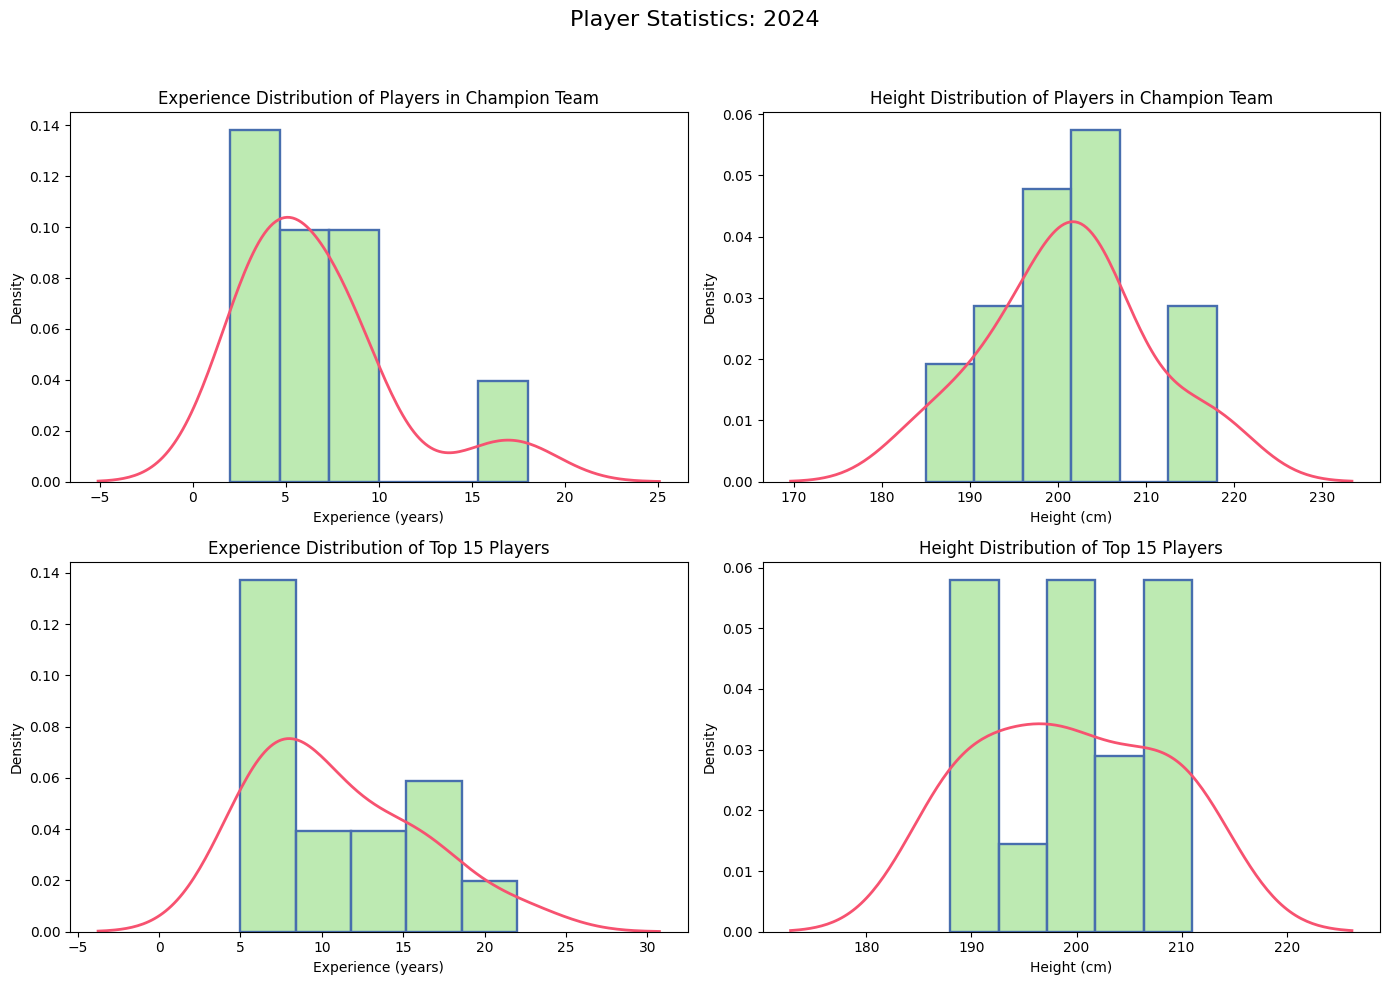

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Experience - Champion Team
sns.histplot(
    lc_players_2024['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0,0]
)
sns.kdeplot(
    lc_players_2024['exp'],
    color='#F75270',
    lw=2,
    ax=axes[0,0]
)
axes[0,0].set_title('Experience Distribution of Players in Champion Team')
axes[0,0].set_xlabel('Experience (years)')
axes[0,0].set_ylabel('Density')

# Height - Champion Team
sns.histplot(
    lc_players_2024['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0,1]
)
sns.kdeplot(
    lc_players_2024['height'],
    color='#F75270',
    lw=2,
    ax=axes[0,1]
)
axes[0,1].set_title('Height Distribution of Players in Champion Team')
axes[0,1].set_xlabel('Height (cm)')
axes[0,1].set_ylabel('Density')

# Experience - Top 15 Players
sns.histplot(
    ts_players_top_15_2024['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1,0]
)
sns.kdeplot(
    ts_players_top_15_2024['exp'],
    color='#F75270',
    lw=2,
    ax=axes[1,0]
)
axes[1,0].set_title('Experience Distribution of Top 15 Players')
axes[1,0].set_xlabel('Experience (years)')
axes[1,0].set_ylabel('Density')

# Height - Top 15 Players
sns.histplot(
    ts_players_top_15_2024['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1,1]
)
sns.kdeplot(
    ts_players_top_15_2024['height'],
    color='#F75270',
    lw=2,
    ax=axes[1,1]
)
axes[1,1].set_title('Height Distribution of Top 15 Players')
axes[1,1].set_xlabel('Height (cm)')
axes[1,1].set_ylabel('Density')

fig.suptitle('Player Statistics: 2024', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

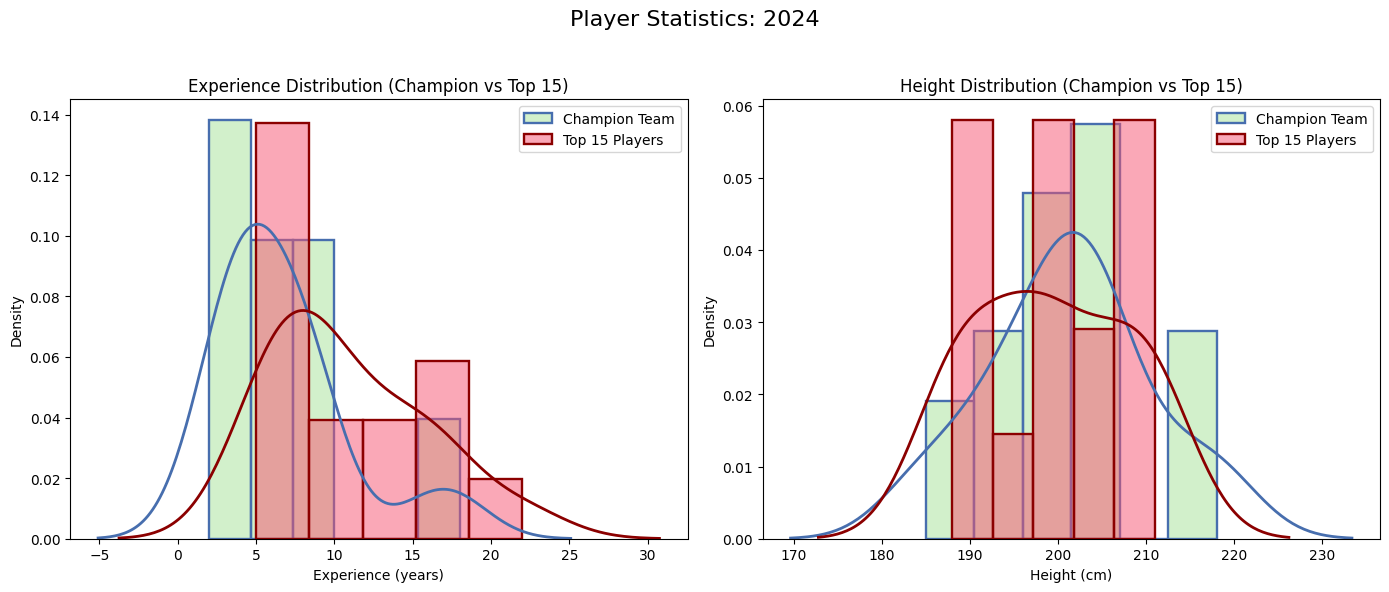

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    lc_players_2024['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0],
    alpha=0.5,
    label='Champion Team'
)
sns.kdeplot(
    lc_players_2024['exp'],
    color='#476EAE',
    lw=2,
    ax=axes[0]
)
sns.histplot(
    ts_players_top_15_2024['exp'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    ax=axes[0],
    alpha=0.5,
    label='Top 15 Players'
)
sns.kdeplot(
    ts_players_top_15_2024['exp'],
    color='#8B0000',
    lw=2,
    ax=axes[0]
)
axes[0].set_title('Experience Distribution (Champion vs Top 15)')
axes[0].set_xlabel('Experience (years)')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.histplot(
    lc_players_2024['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1],
    alpha=0.5,
    label='Champion Team'
)
sns.kdeplot(
    lc_players_2024['height'],
    color='#476EAE',
    lw=2,
    ax=axes[1]
)
sns.histplot(
    ts_players_top_15_2024['height'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    ax=axes[1],
    alpha=0.5,
    label='Top 15 Players'
)
sns.kdeplot(
    ts_players_top_15_2024['height'],
    color='#8B0000',
    lw=2,
    ax=axes[1]
)
axes[1].set_title('Height Distribution (Champion vs Top 15)')
axes[1].set_xlabel('Height (cm)')
axes[1].set_ylabel('Density')
axes[1].legend()

fig.suptitle('Player Statistics: 2024', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [36]:
eh_lc_players_24 = lc_players_2024[['exp', 'height']].describe()
eh_lc_players_24

,exp,height
count,19.000000,19.000000
mean,6.684211,201.263158
std,4.256402,9.218593
min,2.000000,185.000000
25%,4.000000,195.500000
50%,5.000000,201.000000
75%,8.000000,206.000000
max,18.000000,218.000000


In [37]:
eh_ts_players_24 = ts_players_top_15_2024[['exp', 'height']].describe()
eh_ts_players_24

,exp,height
count,15.000000,15.000000
mean,10.866667,199.266667
std,5.012366,8.705226
min,5.000000,188.000000
25%,7.000000,191.500000
50%,10.000000,198.000000
75%,14.500000,207.000000
max,22.000000,211.000000


### 2025

In [38]:
lc_players_2025 = lc_players[lc_players['season'] == 2025]
lc_players_2025

,player_id,name,age,height,weight,exp,season,player_group,rank,points
0,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2025,League Champion,NaN,NaN
1,willija06,Jalen Williams,23,198,99,3,2025,League Champion,NaN,NaN
2,dortlu01,Luguentz Dort,25,193,99,6,2025,League Champion,NaN,NaN
3,harteis01,Isaiah Hartenstein,26,213,115,7,2025,League Champion,NaN,NaN
4,wallaca01,Cason Wallace,21,193,92,2,2025,League Champion,NaN,NaN
5,holmgch01,Chet Holmgren,22,216,96,2,2025,League Champion,NaN,NaN
6,wiggiaa01,Aaron Wiggins,26,198,90,4,2025,League Champion,NaN,NaN
7,joeis01,Isaiah Joe,25,196,82,5,2025,League Champion,NaN,NaN
8,carusal01,Alex Caruso,30,196,84,8,2025,League Champion,NaN,NaN
9,willija07,Jaylin Williams,22,203,113,3,2025,League Champion,NaN,NaN


In [39]:
ts_players_2025 = ts_players[ts_players['season'] == 2025]
ts_players_top_15_2025 = ts_players_2025.sort_values(by='points', ascending=False).head(15)
ts_players_top_15_2025

,player_id,name,age,height,weight,exp,season,player_group,rank,points
200,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2025,Total Stat,1.0,2484.0
201,edwaran01,Anthony Edwards,23,193,102,5,2025,Total Stat,2.0,2177.0
202,jokicni01,Nikola Jokić,29,211,128,10,2025,Total Stat,3.0,2071.0
203,antetgi01,Giannis Antetokounmpo,30,211,109,12,2025,Total Stat,4.0,2036.0
204,tatumja01,Jayson Tatum,26,203,95,8,2025,Total Stat,5.0,1932.0
205,bookede01,Devin Booker,28,198,93,10,2025,Total Stat,6.0,1923.0
206,youngtr01,Trae Young,26,185,74,7,2025,Total Stat,7.0,1841.0
207,herroty01,Tyler Herro,25,196,88,6,2025,Total Stat,8.0,1840.0
208,cunnica01,Cade Cunningham,23,198,99,4,2025,Total Stat,9.0,1830.0
209,hardeja01,James Harden,35,196,99,16,2025,Total Stat,10.0,1802.0


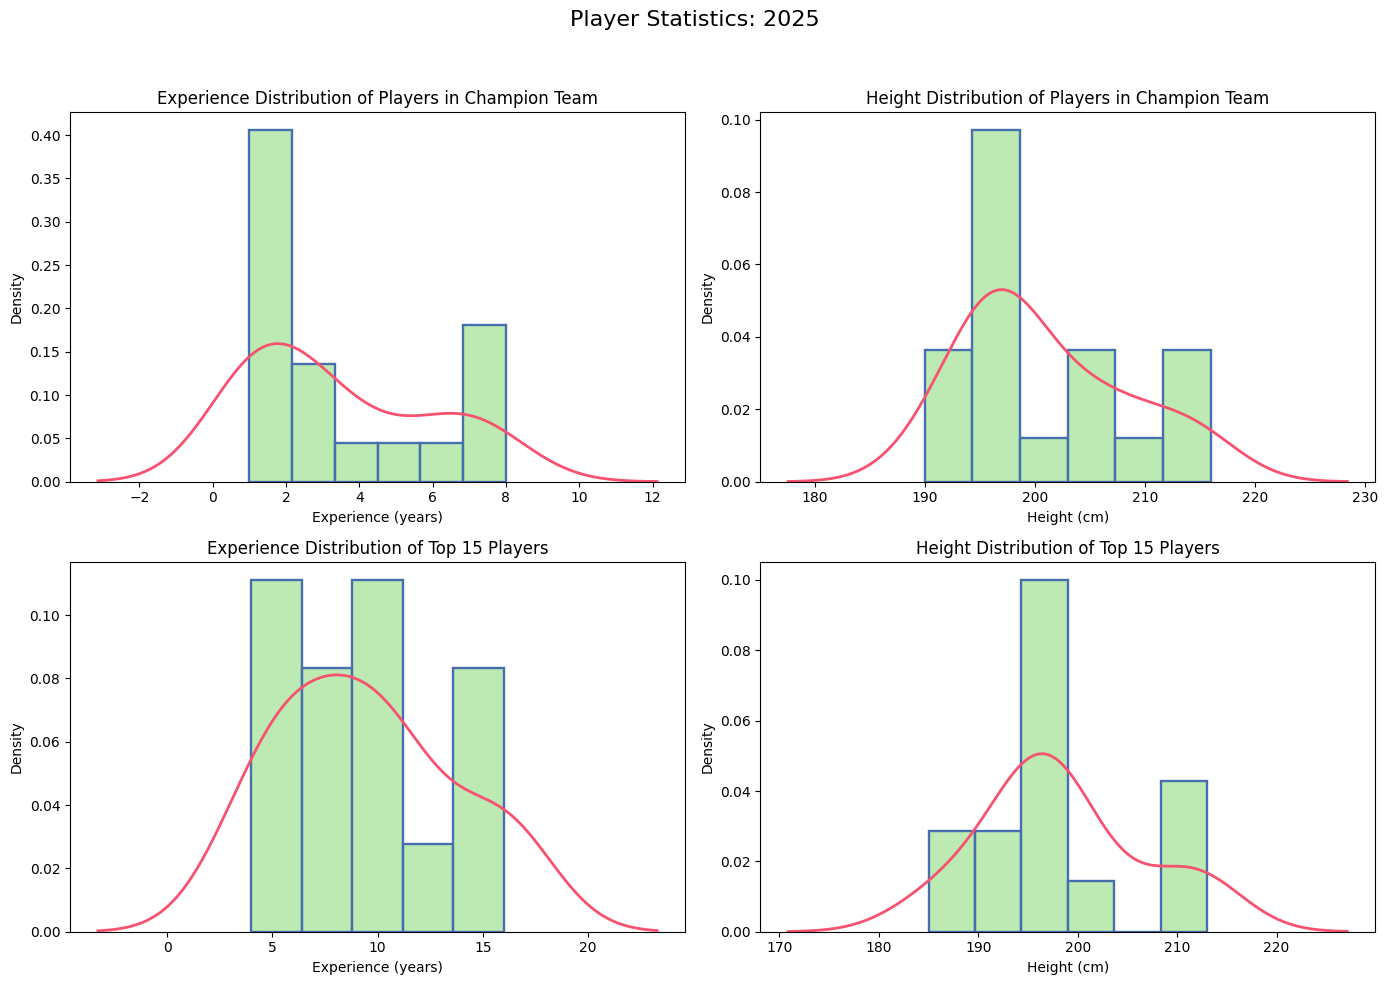

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Experience - Champion Team
sns.histplot(
    lc_players_2025['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0,0]
)
sns.kdeplot(
    lc_players_2025['exp'],
    color='#F75270',
    lw=2,
    ax=axes[0,0]
)
axes[0,0].set_title('Experience Distribution of Players in Champion Team')
axes[0,0].set_xlabel('Experience (years)')
axes[0,0].set_ylabel('Density')

# Height - Champion Team
sns.histplot(
    lc_players_2025['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0,1]
)
sns.kdeplot(
    lc_players_2025['height'],
    color='#F75270',
    lw=2,
    ax=axes[0,1]
)
axes[0,1].set_title('Height Distribution of Players in Champion Team')
axes[0,1].set_xlabel('Height (cm)')
axes[0,1].set_ylabel('Density')

# Experience - Top 15 Players
sns.histplot(
    ts_players_top_15_2025['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1,0]
)
sns.kdeplot(
    ts_players_top_15_2025['exp'],
    color='#F75270',
    lw=2,
    ax=axes[1,0]
)
axes[1,0].set_title('Experience Distribution of Top 15 Players')
axes[1,0].set_xlabel('Experience (years)')
axes[1,0].set_ylabel('Density')

# Height - Top 15 Players
sns.histplot(
    ts_players_top_15_2025['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1,1]
)
sns.kdeplot(
    ts_players_top_15_2025['height'],
    color='#F75270',
    lw=2,
    ax=axes[1,1]
)
axes[1,1].set_title('Height Distribution of Top 15 Players')
axes[1,1].set_xlabel('Height (cm)')
axes[1,1].set_ylabel('Density')

fig.suptitle('Player Statistics: 2025', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

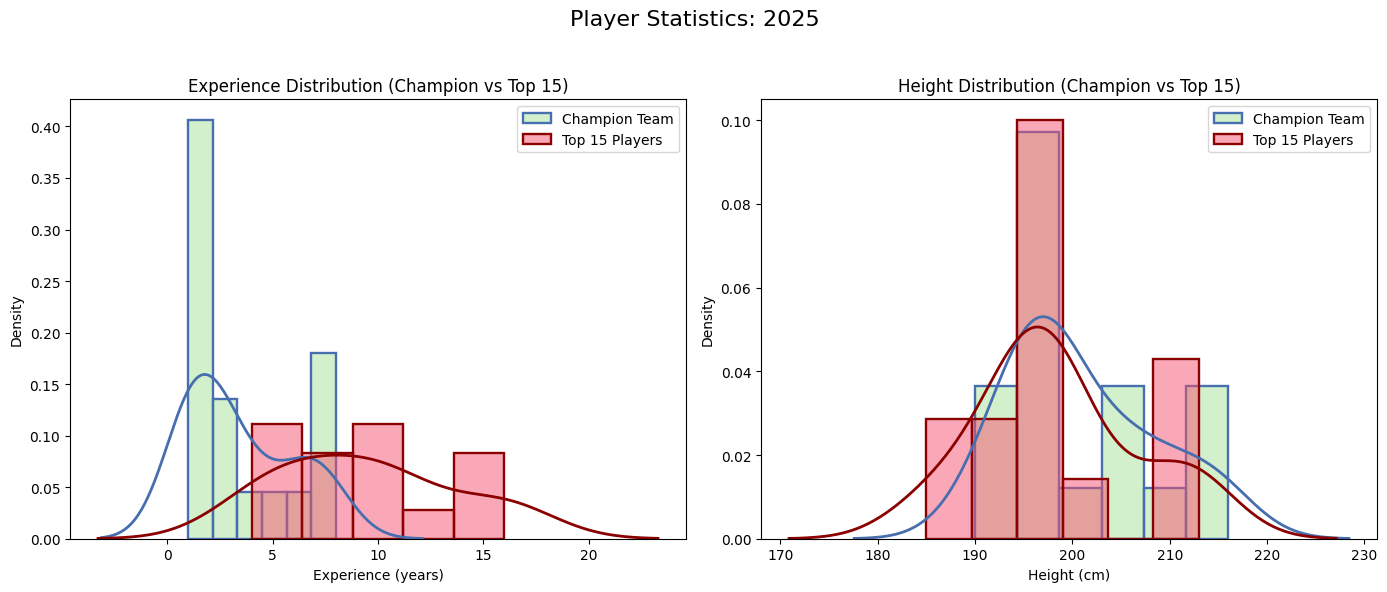

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    lc_players_2025['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0],
    alpha=0.5,
    label='Champion Team'
)
sns.kdeplot(
    lc_players_2025['exp'],
    color='#476EAE',
    lw=2,
    ax=axes[0]
)
sns.histplot(
    ts_players_top_15_2025['exp'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    ax=axes[0],
    alpha=0.5,
    label='Top 15 Players'
)
sns.kdeplot(
    ts_players_top_15_2025['exp'],
    color='#8B0000',
    lw=2,
    ax=axes[0]
)
axes[0].set_title('Experience Distribution (Champion vs Top 15)')
axes[0].set_xlabel('Experience (years)')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.histplot(
    lc_players_2025['height'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1],
    alpha=0.5,
    label='Champion Team'
)
sns.kdeplot(
    lc_players_2025['height'],
    color='#476EAE',
    lw=2,
    ax=axes[1]
)
sns.histplot(
    ts_players_top_15_2025['height'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    ax=axes[1],
    alpha=0.5,
    label='Top 15 Players'
)
sns.kdeplot(
    ts_players_top_15_2025['height'],
    color='#8B0000',
    lw=2,
    ax=axes[1]
)
axes[1].set_title('Height Distribution (Champion vs Top 15)')
axes[1].set_xlabel('Height (cm)')
axes[1].set_ylabel('Density')
axes[1].legend()

fig.suptitle('Player Statistics: 2025', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [42]:
eh_lc_players_25 = lc_players_2025[['exp', 'height']].describe()
eh_lc_players_25

,exp,height
count,19.000000,19.000000
mean,3.421053,200.947368
std,2.479153,7.457090
min,1.000000,190.000000
25%,1.000000,196.000000
50%,3.000000,198.000000
75%,5.500000,206.000000
max,8.000000,216.000000


In [43]:
eh_ts_players_25 = ts_players_top_15_2025[['exp', 'height']].describe()
eh_ts_players_25

,exp,height
count,15.000000,15.000000
mean,9.466667,198.466667
std,4.172472,8.087615
min,4.000000,185.000000
25%,6.500000,194.500000
50%,10.000000,198.000000
75%,11.500000,200.500000
max,16.000000,213.000000


## Identifying Suitable Players

In [44]:
with Session(engine) as s:
    stmt = (
        select(
            Player.id.label('player_id'),
            Player.name,
            Player.age,
            Player.height,
            Player.weight,
            Player.exp,
            Season.season,
            PlayerGroup.player_group,
            Position.position,
            Fact.rank,
            Fact.points
        )
        .join(Fact, Fact.player_id == Player.id)
        .join(Season, Season.id == Fact.season_id)
        .join(PlayerGroup, PlayerGroup.id == Fact.group_id)
        .join(PlayerPosition, PlayerPosition.player_id == Player.id)
        .join(Position, Position.id == PlayerPosition.position_id)
    )

    result = s.execute(stmt)

    df_all_position = pd.DataFrame(result.fetchall(), columns=result.keys())

df_all_position.head()

,player_id,name,age,height,weight,exp,season,player_group,position,rank,points
0,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2025,League Champion,Point Guard,NaN,NaN
1,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2025,League Champion,Shooting Guard,NaN,NaN
2,willija06,Jalen Williams,23,198,99,3,2025,League Champion,Shooting Guard,NaN,NaN
3,willija06,Jalen Williams,23,198,99,3,2025,League Champion,Power Forward,NaN,NaN
4,dortlu01,Luguentz Dort,25,193,99,6,2025,League Champion,Small Forward,NaN,NaN


In [45]:
df_all_position.shape

(643, 11)

In [46]:
position_point_gaurd = df_all_position[df_all_position['position'] == 'Point Guard']
position_point_gaurd_mjt = position_point_gaurd[position_point_gaurd['player_group'] == 'MVP']
position_point_gaurd_mjt_5_seasons = position_point_gaurd_mjt[(position_point_gaurd_mjt['season'] >= 2020) & (position_point_gaurd_mjt['season'] <= 2024)]
position_point_gaurd_mjt_5_seasons

,player_id,name,age,height,weight,exp,season,player_group,position,rank,points
215,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2024,MVP,Point Guard,2.0,NaN
217,doncilu01,Luka Dončić,24,198,104,7,2024,MVP,Point Guard,3.0,NaN
221,antetgi01,Giannis Antetokounmpo,30,211,109,12,2024,MVP,Point Guard,4.0,NaN
223,brunsja01,Jalen Brunson,28,188,86,7,2024,MVP,Point Guard,5.0,NaN
237,antetgi01,Giannis Antetokounmpo,30,211,109,12,2023,MVP,Point Guard,3.0,NaN
241,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2023,MVP,Point Guard,5.0,NaN
244,mitchdo01,Donovan Mitchell,28,190,97,8,2023,MVP,Point Guard,6.0,NaN
247,doncilu01,Luka Dončić,24,198,104,7,2023,MVP,Point Guard,8.0,NaN
249,curryst01,Stephen Curry,36,188,83,16,2023,MVP,Point Guard,9.0,NaN
253,foxde01,De'Aaron Fox,26,190,83,8,2023,MVP,Point Guard,11.0,NaN


In [47]:
best_player = position_point_gaurd_mjt_5_seasons.groupby('name').size().reset_index(name='count')
best_player_sorted = best_player.sort_values(by='count', ascending=False)
best_player_sorted.head(3)

,name,count
7,Giannis Antetokounmpo,5
12,Luka Dončić,5
11,LeBron James,3


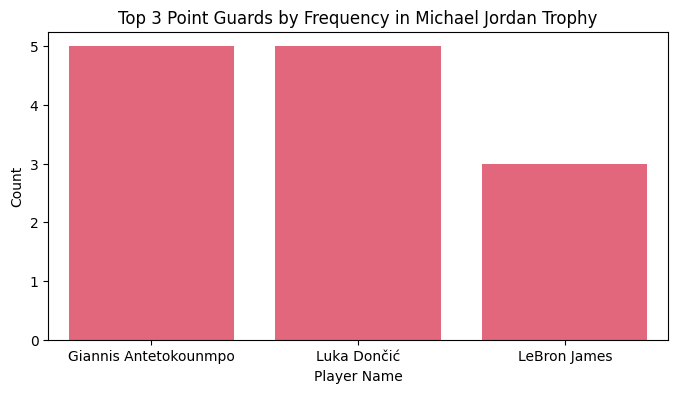

In [48]:
top_players = best_player_sorted.head(3)

plt.figure(figsize=(8, 4))

sns.barplot(data=top_players, x='name', y='count', color='#F75270')

plt.xlabel('Player Name')
plt.ylabel('Count')
plt.title('Top 3 Point Guards by Frequency in Michael Jordan Trophy')
plt.show()

# Hypothesis

<p style='font-family: Vazir; font-size:20px; direction:rtl; text-align:right;'>
اگر مقدار p-value > 0.05 باشد ← داده نرمال است.
<br><br>
اگر مقدار p-value < 0.05 باشد ← داده نرمال نیست. 
</p>

<p style='font-family: Vazir; font-size:20px; direction:rtl; text-align:right;'>
اگر مقدار p-value > 0.05 باشد ← تفاوت معناداری وجود ندارد و فرض صفر (H₀) رد نمی‌شود.  
<br><br>
اگر مقدار p-value < 0.05 باشد ← تفاوت معنادار است و فرض صفر (H₀) رد می‌شود.  
</p>

## First Hypothesis
Increase in the Average Agility of the Top 20 Players Compared to the Past: A Comparison of the 2023–2024 and 2021–2022 Seasons
<br><br>
agility = height / weight

In [49]:
ts_players_top_20 = ts_players.sort_values(by='points', ascending=False).groupby('season').head(20)
ts_players_top_20['agility'] = ts_players_top_20['height'] / ts_players_top_20['weight']
ts_players_top_20

,player_id,name,age,height,weight,exp,season,player_group,rank,points,agility
200,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2025,Total Stat,1.0,2484.0,2.200000
225,doncilu01,Luka Dončić,24,198,104,7,2024,Total Stat,1.0,2370.0,1.903846
325,hardeja01,James Harden,35,196,99,16,2020,Total Stat,1.0,2335.0,1.979798
226,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2024,Total Stat,2.0,2254.0,2.200000
250,tatumja01,Jayson Tatum,26,203,95,8,2023,Total Stat,1.0,2225.0,2.136842
...,...,...,...,...,...,...,...,...,...,...,...
317,ingrabr01,Brandon Ingram,23,203,86,9,2021,Total Stat,18.0,1450.0,2.360465
318,westbru01,Russell Westbrook,33,193,90,17,2021,Total Stat,19.0,1445.0,2.144444
319,brownja02,Jaylen Brown,27,198,101,9,2021,Total Stat,20.0,1430.0,1.960396
343,harrito02,Tobias Harris,27,203,102,14,2020,Total Stat,19.0,1411.0,1.990196


In [50]:
ts_players_past_seasons_agility = ts_players_top_20[(ts_players_top_20['season'] >= 2021) & (ts_players_top_20['season'] <= 2022)]
past_agility_mean = ts_players_past_seasons_agility['agility'].mean()
print(f'Average Agility (Past Seasons): {past_agility_mean:.3f}')

Average Agility (Past Seasons): 2.038


In [51]:
ts_players_recent_seasons_agility = ts_players_top_20[(ts_players_top_20['season'] >= 2023) & (ts_players_top_20['season'] <= 2024)]
recent_agility_mean = ts_players_recent_seasons_agility['agility'].mean()
print(f'Average Agility (Recent Seasons): {recent_agility_mean:.3f}')

Average Agility (Recent Seasons): 2.039


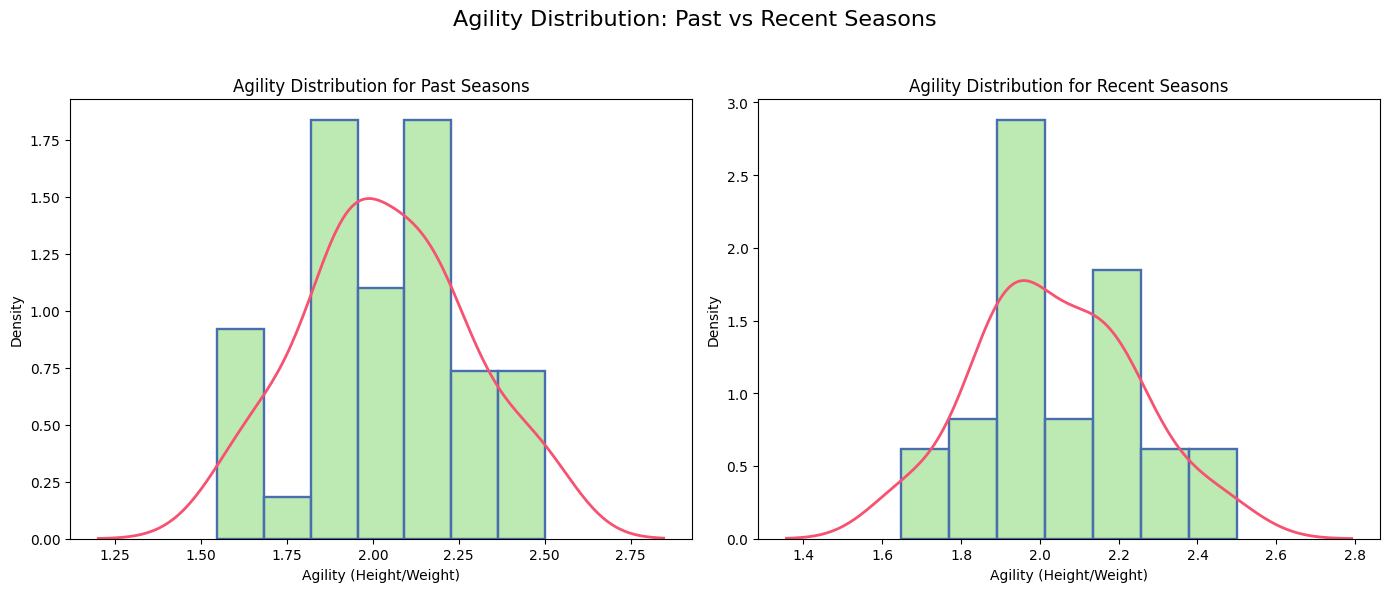

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    ts_players_past_seasons_agility['agility'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0]
)
sns.kdeplot(
    ts_players_past_seasons_agility['agility'],
    color='#F75270',
    lw=2,
    ax=axes[0]
)
axes[0].set_title('Agility Distribution for Past Seasons')
axes[0].set_xlabel('Agility (Height/Weight)')
axes[0].set_ylabel('Density')

sns.histplot(
    ts_players_recent_seasons_agility['agility'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1]
)
sns.kdeplot(
    ts_players_recent_seasons_agility['agility'],
    color='#F75270',
    lw=2,
    ax=axes[1]
)
axes[1].set_title('Agility Distribution for Recent Seasons')
axes[1].set_xlabel('Agility (Height/Weight)')
axes[1].set_ylabel('Density')

fig.suptitle('Agility Distribution: Past vs Recent Seasons', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

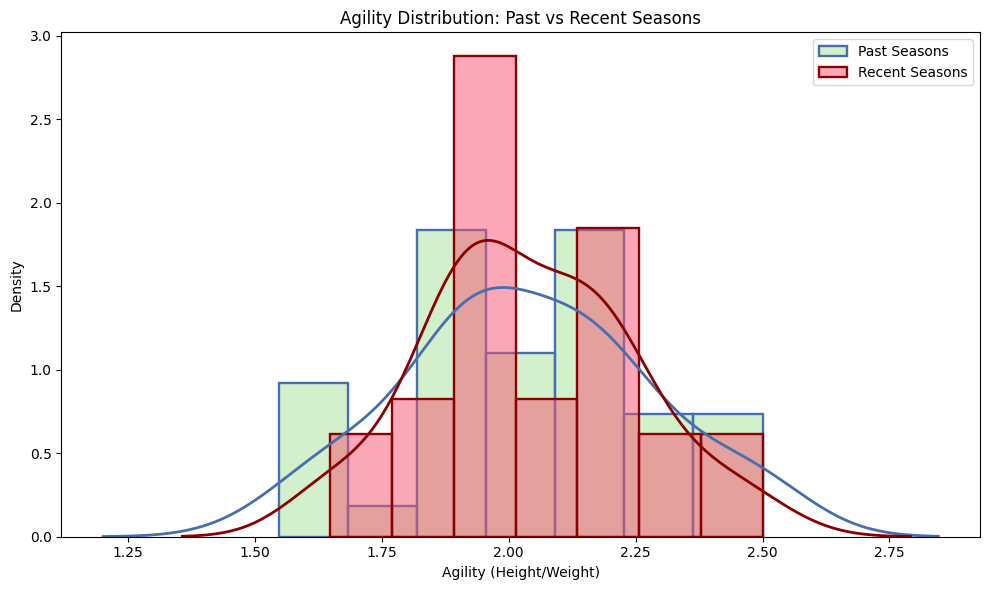

In [53]:
plt.figure(figsize=(10, 6))

sns.histplot(
    ts_players_past_seasons_agility['agility'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Past Seasons'
)
sns.kdeplot(
    ts_players_past_seasons_agility['agility'],
    color='#476EAE',
    lw=2
)

sns.histplot(
    ts_players_recent_seasons_agility['agility'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Recent Seasons'
)
sns.kdeplot(
    ts_players_recent_seasons_agility['agility'],
    color='#8B0000',
    lw=2
)

plt.title('Agility Distribution: Past vs Recent Seasons')
plt.xlabel('Agility (Height/Weight)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
agility_past_seasons = ts_players_past_seasons_agility['agility'].describe()
agility_past_seasons

count    40.000000
mean      2.037784
std       0.241244
min       1.546875
25%       1.903331
50%       1.985294
75%       2.177778
max       2.500000
Name: agility, dtype: float64

In [55]:
agility_recent_seasons = ts_players_recent_seasons_agility['agility'].describe()
agility_recent_seasons

count    40.000000
mean      2.039422
std       0.203159
min       1.648438
25%       1.903846
50%       2.000000
75%       2.179845
max       2.500000
Name: agility, dtype: float64

In [56]:
past_agility = ts_players_past_seasons_agility['agility']
recent_agility = ts_players_recent_seasons_agility['agility']

stat_past, p_value_past = shapiro(past_agility)
print(f'Past Seasons: p-value = {p_value_past:.3f}')
if p_value_past > 0.05:
    print('Data is normal.')
else:
    print('Data is NOT normal.')

stat_recent, p_value_recent = shapiro(recent_agility)
print(f'Recent Seasons: p-value = {p_value_recent:.3f}')
if p_value_recent > 0.05:
    print('Data is normal.')
else:
    print('Data is NOT normal.')

Past Seasons: p-value = 0.437
Data is normal.
Recent Seasons: p-value = 0.578
Data is normal.


In [57]:
past_agility = ts_players_past_seasons_agility['agility']
recent_agility = ts_players_recent_seasons_agility['agility']

stat, p_value = ttest_ind(recent_agility, past_agility, equal_var=False)

print(f'T-test statistic: {stat:.3f}, \nP-value: {p_value:.3f}')

if p_value > 0.05:
    print('No significant difference → Fail to reject H₀')
else:
    print('Significant difference → Reject H₀')

T-test statistic: 0.033, 
P-value: 0.974
No significant difference → Fail to reject H₀


<p dir='rtl'>
میانگین چابکی بازیکنان برتر در فصل‌های گذشته برابر با 2.038 و در فصل‌های اخیر برابر با 2.029 بوده است. این دو مقدار بسیار به یکدیگر نزدیک هستند و اختلاف عددی ناچیزی دارند.
<br><br>
آزمون آماری t-test نیز این نتیجه را تایید می‌کند (p-value = 0.974)، به‌طوری که هیچ تفاوت معناداری بین دو گروه مشاهده نشد.
<br><br>
بنابراین می‌توان گفت که هم بر اساس میانگین و هم بر اساس آزمون آماری، ادعای افزایش چابکی بازیکنان در فصل‌های اخیر نسبت به گذشته تایید نمی‌شود.
</p>

## Second Hypothesis

Increase in the Average Innate Ability of Champion Team Players Compared to the Past: A Comparison of the 2023–2024 and 2021–2022 Seasons
<br><br>
Innate Ability = experience / age

In [58]:
ts_players = ts_players.copy()
ts_players['innate_ability'] = ts_players['exp'] / ts_players['age']
ts_players

,player_id,name,age,height,weight,exp,season,player_group,rank,points,innate_ability
200,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2025,Total Stat,1.0,2484.0,0.269231
201,edwaran01,Anthony Edwards,23,193,102,5,2025,Total Stat,2.0,2177.0,0.217391
202,jokicni01,Nikola Jokić,29,211,128,10,2025,Total Stat,3.0,2071.0,0.344828
203,antetgi01,Giannis Antetokounmpo,30,211,109,12,2025,Total Stat,4.0,2036.0,0.400000
204,tatumja01,Jayson Tatum,26,203,95,8,2025,Total Stat,5.0,1932.0,0.307692
...,...,...,...,...,...,...,...,...,...,...,...
345,siakapa01,Pascal Siakam,30,203,104,9,2020,Total Stat,21.0,1371.0,0.300000
346,sextoco01,Collin Sexton,22,190,86,7,2020,Total Stat,22.0,1349.0,0.318182
347,gilgesh01,Shai Gilgeous-Alexander,26,198,90,7,2020,Total Stat,23.0,1331.0,0.269231
348,warretj01,T.J. Warren,26,203,99,9,2020,Total Stat,24.0,1326.0,0.346154


In [59]:
ts_players_past_seasons_ability = ts_players[(ts_players['season'] >= 2021) & (ts_players['season'] <= 2022)]
past_ability_mean = ts_players_past_seasons_ability['innate_ability'].mean()
print(f'Average Ability (Past Seasons): {past_ability_mean:.3f}')

Average Ability (Past Seasons): 0.359


In [60]:
ts_players_recent_seasons_ability = ts_players[(ts_players['season'] >= 2023) & (ts_players['season'] <= 2024)]
recent_ability_mean = ts_players_recent_seasons_ability['innate_ability'].mean()
print(f'Average Ability (Recent Seasons): {recent_ability_mean:.3f}')

Average Ability (Recent Seasons): 0.331


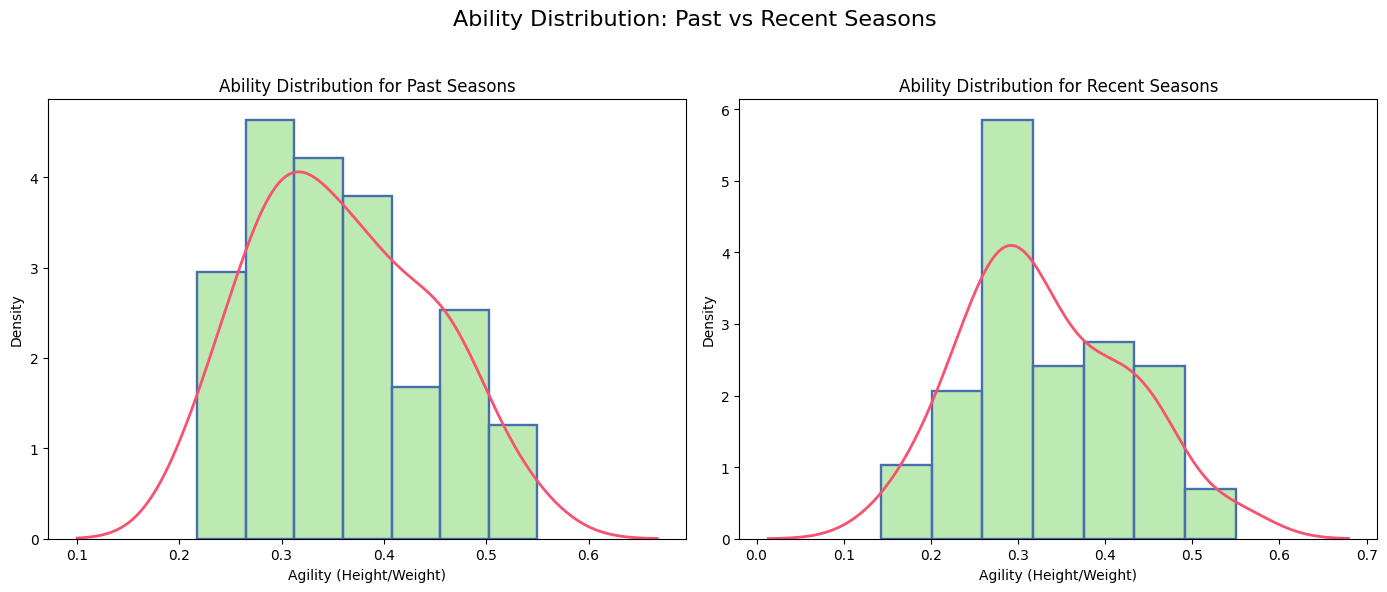

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    ts_players_past_seasons_ability['innate_ability'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0]
)
sns.kdeplot(
    ts_players_past_seasons_ability['innate_ability'],
    color='#F75270',
    lw=2,
    ax=axes[0]
)
axes[0].set_title('Ability Distribution for Past Seasons')
axes[0].set_xlabel('Agility (Height/Weight)')
axes[0].set_ylabel('Density')

sns.histplot(
    ts_players_recent_seasons_ability['innate_ability'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1]
)
sns.kdeplot(
    ts_players_recent_seasons_ability['innate_ability'],
    color='#F75270',
    lw=2,
    ax=axes[1]
)
axes[1].set_title('Ability Distribution for Recent Seasons')
axes[1].set_xlabel('Agility (Height/Weight)')
axes[1].set_ylabel('Density')

fig.suptitle('Ability Distribution: Past vs Recent Seasons', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

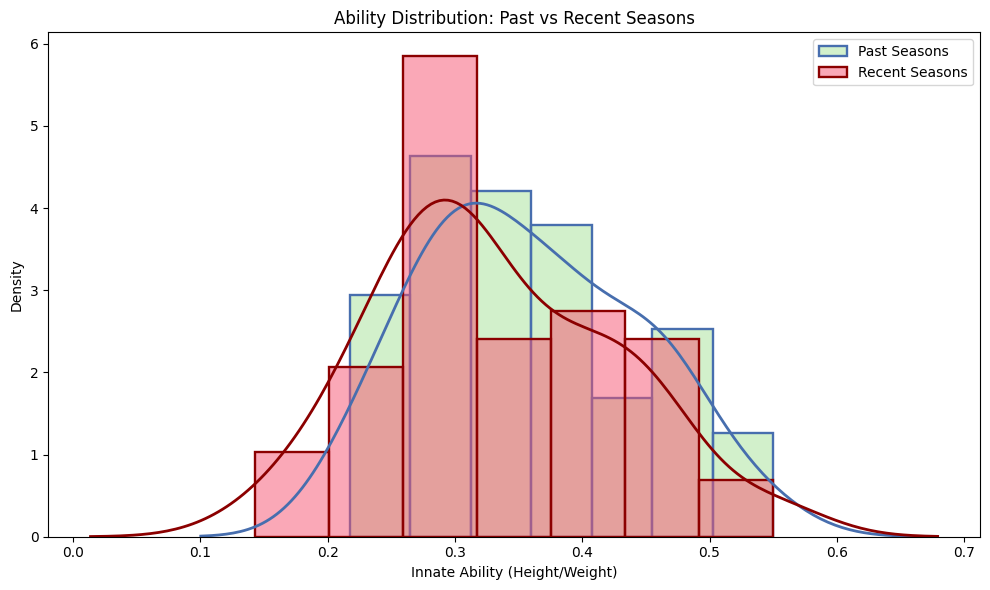

In [62]:
plt.figure(figsize=(10, 6))

sns.histplot(
    ts_players_past_seasons_ability['innate_ability'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Past Seasons'
)
sns.kdeplot(
    ts_players_past_seasons_ability['innate_ability'],
    color='#476EAE',
    lw=2
)

sns.histplot(
    ts_players_recent_seasons_ability['innate_ability'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Recent Seasons'
)
sns.kdeplot(
    ts_players_recent_seasons_ability['innate_ability'],
    color='#8B0000',
    lw=2
)

plt.title('Ability Distribution: Past vs Recent Seasons')
plt.xlabel('Innate Ability (Height/Weight)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
ability_past_seasons = ts_players_past_seasons_ability['innate_ability'].describe()
ability_past_seasons

count    50.000000
mean      0.358519
std       0.085374
min       0.217391
25%       0.292824
50%       0.344828
75%       0.430000
max       0.550000
Name: innate_ability, dtype: float64

In [64]:
ability_recent_seasons = ts_players_recent_seasons_ability['innate_ability'].describe()
ability_recent_seasons

count    50.000000
mean      0.331425
std       0.094199
min       0.142857
25%       0.262960
50%       0.307692
75%       0.398485
max       0.550000
Name: innate_ability, dtype: float64

In [65]:
past_ability = ts_players_past_seasons_ability['innate_ability']
recent_ability = ts_players_recent_seasons_ability['innate_ability']

stat_past, p_value_past = shapiro(past_agility)
print(f'Past Seasons: p-value = {p_value_past:.3f}')
if p_value_past > 0.05:
    print('Data is normal.')
else:
    print('Data is NOT normal.')

stat_recent, p_value_recent = shapiro(recent_agility)
print(f'Recent Seasons: p-value = {p_value_recent:.3f}')
if p_value_recent > 0.05:
    print('Data is normal.')
else:
    print('Data is NOT normal.')

Past Seasons: p-value = 0.437
Data is normal.
Recent Seasons: p-value = 0.578
Data is normal.


In [66]:
past_ability = ts_players_past_seasons_ability['innate_ability']
recent_ability = ts_players_recent_seasons_ability['innate_ability']

stat, p_value = ttest_ind(recent_ability, past_ability, equal_var=False)

print(f'T-test statistic: {stat:.3f}, \nP-value: {p_value:.3f}')

if p_value > 0.05:
    print('No significant difference → Fail to reject H₀')
else:
    print('Significant difference → Reject H₀')

T-test statistic: -1.507, 
P-value: 0.135
No significant difference → Fail to reject H₀


<p dir='rtl'>
میانگین توانایی ذاتی بازیکنان برتر در فصل‌های گذشته برابر با 0.359 و در فصل‌های اخیر برابر با 0.331 بوده است. این دو مقدار بسیار به یکدیگر نزدیک هستند و اختلاف عددی ناچیزی دارند.
<br><br>
آزمون آماری t-test نیز این نتیجه را تایید می‌کند (p-value = 0.135)، به‌طوری که هیچ تفاوت معناداری بین دو گروه مشاهده نشد.
<br><br>
بنابراین می‌توان گفت که هم بر اساس میانگین و هم بر اساس آزمون آماری، ادعای افزایش توانایی ذاتی بازیکنان در فصل‌های اخیر نسبت به گذشته تایید نمی‌شود.
</p>

# Additional Analysis

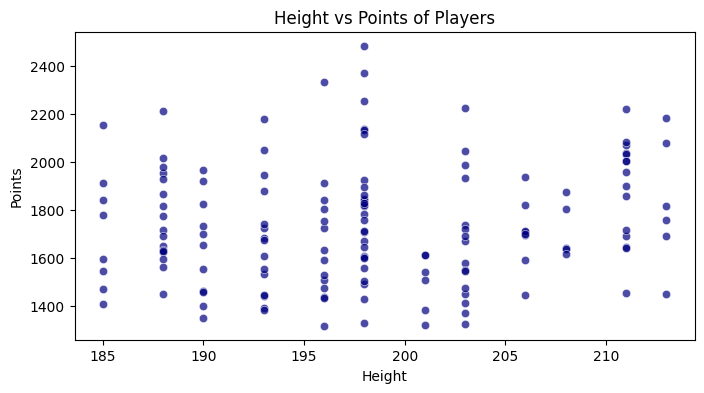

In [67]:
height_points = ts_players[['height', 'points']]

plt.figure(figsize=(8, 4))
sns.scatterplot(data=height_points, x='height', y='points', color='navy', alpha=0.7)
plt.xlabel('Height')
plt.ylabel('Points')
plt.title('Height vs Points of Players')
plt.show()

In [68]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])

fig1 = px.pie(
    df_all_position,
    values='height',
    names='position',
    color='position',
    color_discrete_map={
        'Point Guard': 'lightcyan',
        'Shooting Guard': 'cyan',
        'Small Forward': 'royalblue',
        'Power Forward': 'darkblue',
        'Center': 'navy'
    }
)
fig.add_trace(fig1.data[0], row=1, col=1)

fig2 = px.pie(
    df_all_position,
    values='weight',
    names='position',
    color='position',
    color_discrete_map={
        'Point Guard': 'lightcyan',
        'Shooting Guard': 'cyan',
        'Small Forward': 'royalblue',
        'Power Forward': 'darkblue',
        'Center': 'navy'
    }
)
fig.add_trace(fig2.data[0], row=1, col=2)

fig3 = px.pie(
    df_all_position,
    values='exp',
    names='position',
    color='position',
    color_discrete_map={
        'Point Guard': 'lightcyan',
        'Shooting Guard': 'cyan',
        'Small Forward': 'royalblue',
        'Power Forward': 'darkblue',
        'Center': 'navy'
    }
)
fig.add_trace(fig3.data[0], row=1, col=3)

fig.update_layout(title_text="Player Distribution by Height, Weight, Experience")
fig.show()

In [69]:
fig = px.scatter_matrix(
    df_all,
    dimensions=['height', 'weight', 'season'], 
    color='season',
    color_continuous_scale='twilight',  
    title='Pairplot of Best Players'
)

fig.update_traces(diagonal_visible=True)  
fig.show()

## Third Hypothesis

Point guards are composed of heavier players compared to those in other positions.

In [70]:
all_point_guard_weight = df_all_position[df_all_position['position'] == 'Point Guard']
all_non_point_guard_weight = df_all_position[df_all_position['position'] != 'Point Guard']

point_guard_weight_mean = all_point_guard_weight['weight'].mean()
non_point_guard_weight_mean = all_non_point_guard_weight['weight'].mean()

print(f'Average Weight of Point Guards Player: {point_guard_weight_mean:.3f}')
print(f'Average Weight of non Point Guards Player: {non_point_guard_weight_mean:.3f}')

Average Weight of Point Guards Player: 92.637
Average Weight of non Point Guards Player: 102.623


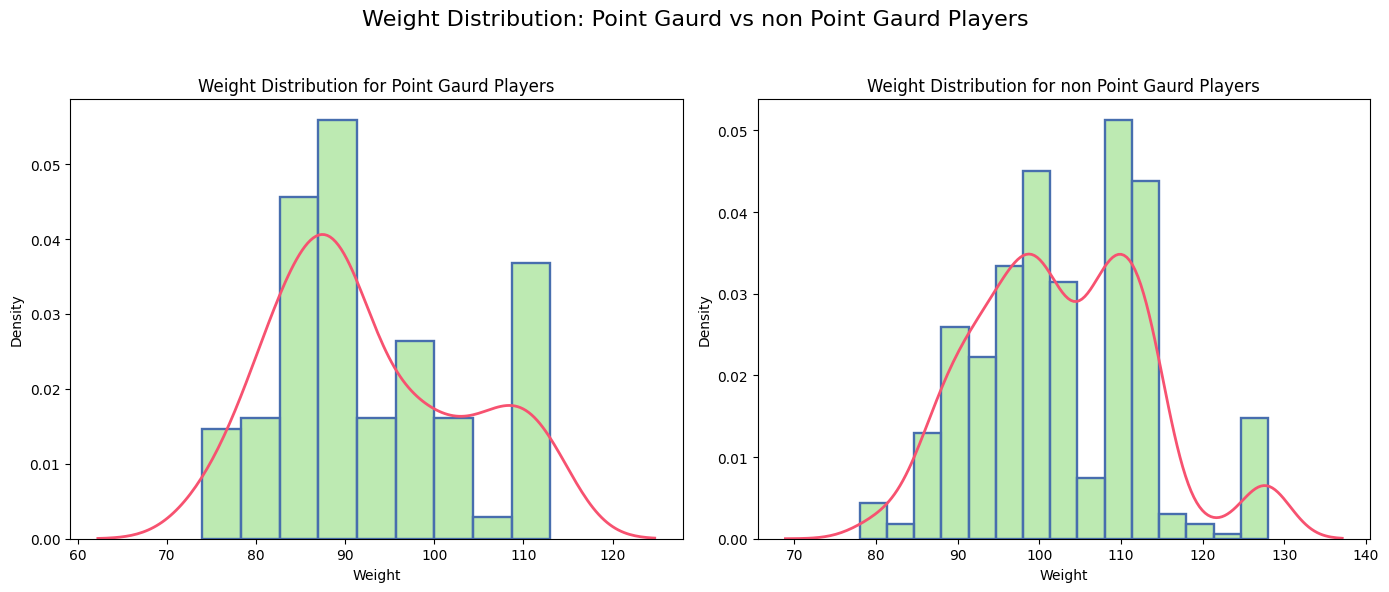

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    all_point_guard_weight['weight'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0]
)
sns.kdeplot(
    all_point_guard_weight['weight'],
    color='#F75270',
    lw=2,
    ax=axes[0]
)
axes[0].set_title('Weight Distribution for Point Gaurd Players')
axes[0].set_xlabel('Weight')
axes[0].set_ylabel('Density')

sns.histplot(
    all_non_point_guard_weight['weight'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1]
)
sns.kdeplot(
    all_non_point_guard_weight['weight'],
    color='#F75270',
    lw=2,
    ax=axes[1]
)
axes[1].set_title('Weight Distribution for non Point Gaurd Players')
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('Density')

fig.suptitle('Weight Distribution: Point Gaurd vs non Point Gaurd Players', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

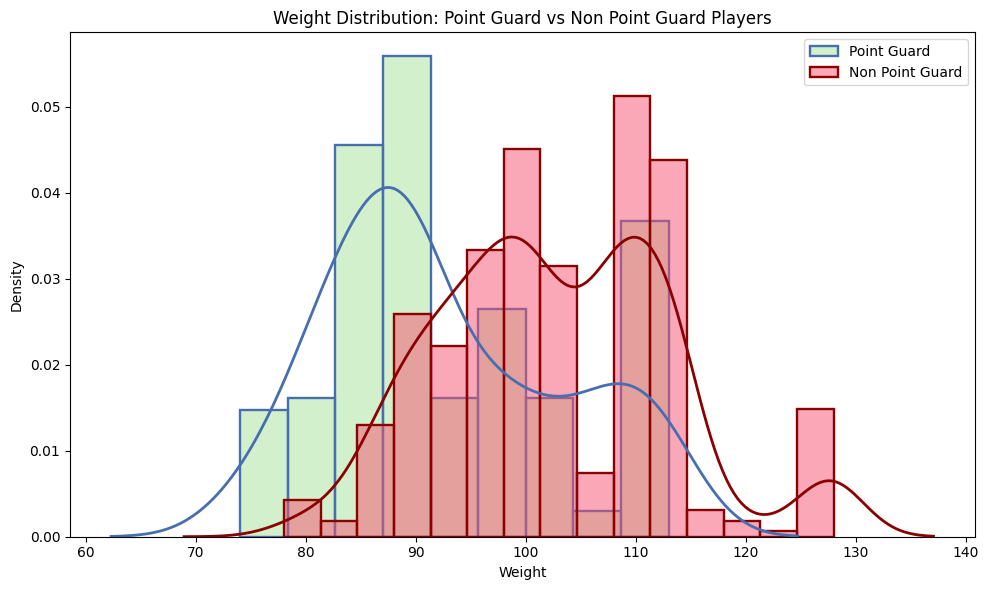

In [72]:
plt.figure(figsize=(10, 6))

sns.histplot(
    all_point_guard_weight['weight'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Point Guard'
)
sns.kdeplot(
    all_point_guard_weight['weight'],
    color='#476EAE',
    lw=2
)

sns.histplot(
    all_non_point_guard_weight['weight'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Non Point Guard'
)
sns.kdeplot(
    all_non_point_guard_weight['weight'],
    color='#8B0000',
    lw=2
)

plt.title('Weight Distribution: Point Guard vs Non Point Guard Players')
plt.xlabel('Weight')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
pg_weight = all_point_guard_weight['weight']
non_pg_weight = all_non_point_guard_weight['weight']

stat_past, p_value_past = shapiro(pg_weight)
print(f'Past Seasons: p-value = {p_value_past:.3f}')
if p_value_past > 0.05:
    print('Data is normal.')
else:
    print('Data is NOT normal.')

stat_recent, p_value_recent = shapiro(non_pg_weight)
print(f'Recent Seasons: p-value = {p_value_recent:.3f}')
if p_value_recent > 0.05:
    print('Data is normal.')
else:
    print('Data is NOT normal.')

Past Seasons: p-value = 0.000
Data is NOT normal.
Recent Seasons: p-value = 0.000
Data is NOT normal.


In [74]:
stat, p_value = mannwhitneyu(pg_weight, non_pg_weight, alternative='two-sided')

print(f'Mann-Whitney U statistic: {stat:.3f}, \nP-value: {p_value:.3f}')

if p_value > 0.05:
    print('No significant difference → Fail to reject H₀')
else:
    print('Significant difference → Reject H₀')

Mann-Whitney U statistic: 19373.500, 
P-value: 0.000
Significant difference → Reject H₀


<p dir="rtl">
میانگین بازیکنان پوزیشن Point Guard برابر با 92.637 و میانگین بازیکنان دیگر پوزیشن‌ها برابر با 102.623 بوده است. این دو مقدار دارای تفاوت هستند. 
<br><br>
آزمون آماری mannwhitneyu نیز این نتیجه را تایید می‌کند (p-value = 0.000)، به‌طوری که تفاوت معناداری بین دو گروه مشاهده می‌شود. 
<br><br>
بنابراین می‌توان گفت که هم بر اساس میانگین و هم بر اساس آزمون آماری، بازیکنان Point Guard به طور معناداری وزن کمتری نسبت به بازیکنان سایر پوزیشن‌ها دارند. 
</p>

## Fourth Hypothesis

Players in the center position are more experienced compared to players in other positions.

In [75]:
all_center_exp = df_all_position[df_all_position['position'] == 'Center']
all_non_center_exp = df_all_position[df_all_position['position'] != 'Center']

center_exp_mean = all_center_exp['exp'].mean()
non_center_exp_mean = all_non_center_exp['exp'].mean()

print(f'Average Experience of Center Player: {center_exp_mean:.3f}')
print(f'Average Experience of non Center Player: {non_center_exp_mean:.3f}')

Average Experience of Center Player: 11.754
Average Experience of non Center Player: 10.725


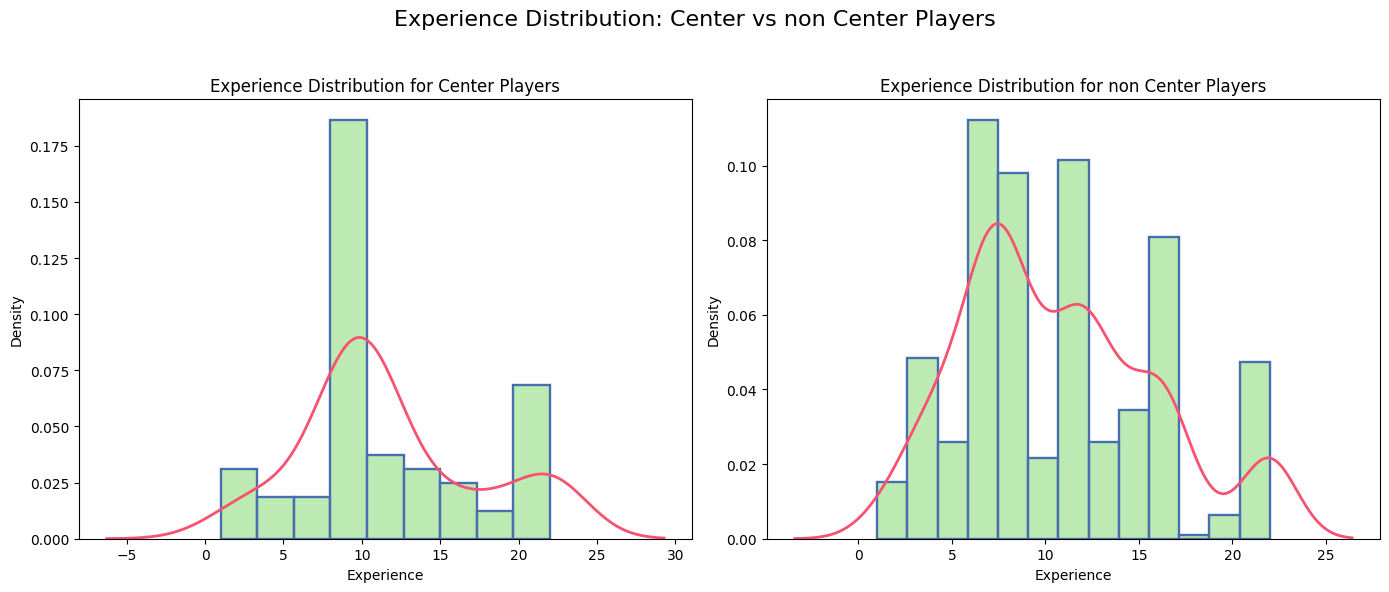

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    all_center_exp['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0]
)
sns.kdeplot(
    all_center_exp['exp'],
    color='#F75270',
    lw=2,
    ax=axes[0]
)
axes[0].set_title('Experience Distribution for Center Players')
axes[0].set_xlabel('Experience')
axes[0].set_ylabel('Density')

sns.histplot(
    all_non_center_exp['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1]
)
sns.kdeplot(
    all_non_center_exp['exp'],
    color='#F75270',
    lw=2,
    ax=axes[1]
)
axes[1].set_title('Experience Distribution for non Center Players')
axes[1].set_xlabel('Experience')
axes[1].set_ylabel('Density')

fig.suptitle('Experience Distribution: Center vs non Center Players', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

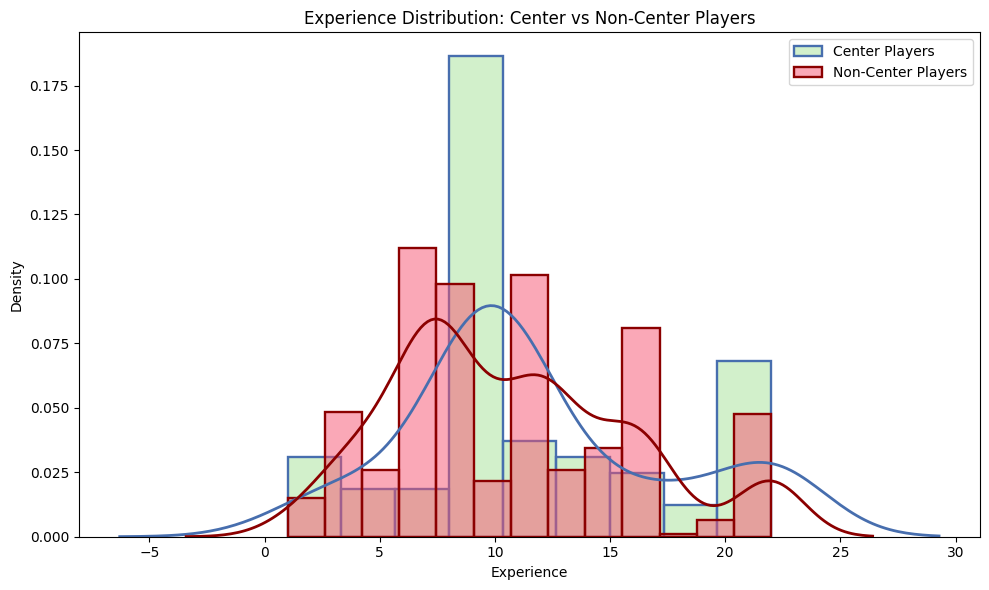

In [77]:
plt.figure(figsize=(10, 6))

sns.histplot(
    all_center_exp['exp'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Center Players'
)
sns.kdeplot(
    all_center_exp['exp'],
    color='#476EAE',
    lw=2
)

sns.histplot(
    all_non_center_exp['exp'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Non-Center Players'
)
sns.kdeplot(
    all_non_center_exp['exp'],
    color='#8B0000',
    lw=2
)

plt.title('Experience Distribution: Center vs Non-Center Players')
plt.xlabel('Experience')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [78]:
center_exp = all_center_exp['exp']
non_center_exp = all_non_center_exp['exp']

stat_past, p_value_past = shapiro(center_exp)
print(f'Past Seasons: p-value = {p_value_past:.3f}')
if p_value_past > 0.05:
    print('Data is normal.')
else:
    print('Data is NOT normal.')

stat_recent, p_value_recent = shapiro(non_center_exp)
print(f'Recent Seasons: p-value = {p_value_recent:.3f}')
if p_value_recent > 0.05:
    print('Data is normal.')
else:
    print('Data is NOT normal.')

Past Seasons: p-value = 0.000
Data is NOT normal.
Recent Seasons: p-value = 0.000
Data is NOT normal.


In [79]:
stat, p_value = mannwhitneyu(center_exp, non_center_exp, alternative='two-sided')

print(f'Mann-Whitney U statistic: {stat:.3f}, \nP-value: {p_value:.3f}')

if p_value > 0.05:
    print('No significant difference → Fail to reject H₀')
else:
    print('Significant difference → Reject H₀')

Mann-Whitney U statistic: 22080.500, 
P-value: 0.117
No significant difference → Fail to reject H₀


<p dir="rtl" >
میانگین بازیکنان پوزیشن Center برابر با 11.754 و میانگین بازیکنان دیگر پوزیشن‌ها برابر با 10.725 بوده است. این دو مقدار اندکی تفاوت دارند. 
<br><br>
آزمون آماری mannwhitneyu نشان می‌دهد که این تفاوت از نظر آماری معنادار نیست (p-value = 0.117).
<br><br>
بنابراین می‌توان گفت که اگرچه میانگین تجربه بازیکنان Center کمی بیشتر از سایر پوزیشن‌ها است، اما این اختلاف بر اساس آزمون آماری معنادار نبوده و فرض صفر رد نمی‌شود. 
</p>

## Fifth Hypothesis

Players taller than the median height have higher points compared to players shorter than the median height.

In [80]:
median_height = ts_players['height'].median()
print(f"Median height: {int(median_height)}")

shorter_group = ts_players[ts_players['height'] <= median_height]
taller_group = ts_players[ts_players['height'] > median_height]

shorter_group_piont = shorter_group['points'].mean()
taller_group_point = taller_group['points'].mean()

print(f'Average Point of short Player: {shorter_group_piont:.3f}')
print(f'Average Point of tall Player: {taller_group_point:.3f}')

Median height: 198
Average Point of short Player: 1733.404
Average Point of tall Player: 1735.554


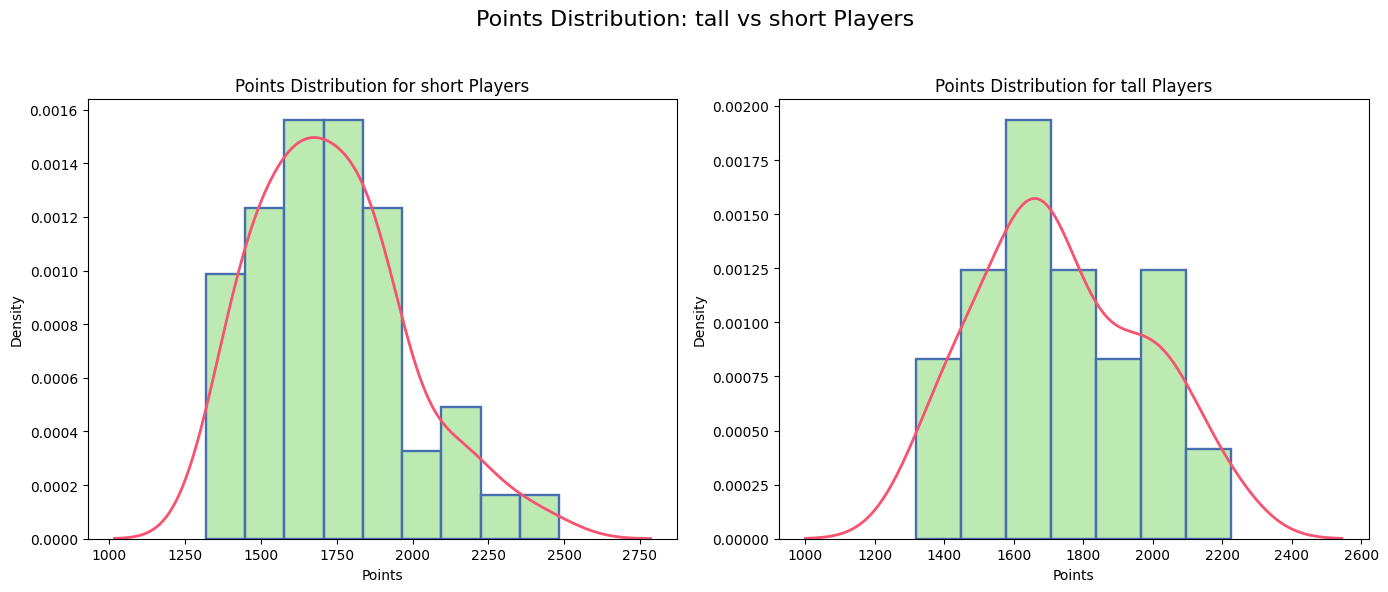

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    shorter_group['points'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[0]
)
sns.kdeplot(
    shorter_group['points'],
    color='#F75270',
    lw=2,
    ax=axes[0]
)
axes[0].set_title('Points Distribution for short Players')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density')

sns.histplot(
    taller_group['points'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    ax=axes[1]
)
sns.kdeplot(
    taller_group['points'],
    color='#F75270',
    lw=2,
    ax=axes[1]
)
axes[1].set_title('Points Distribution for tall Players')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density')

fig.suptitle('Points Distribution: tall vs short Players', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

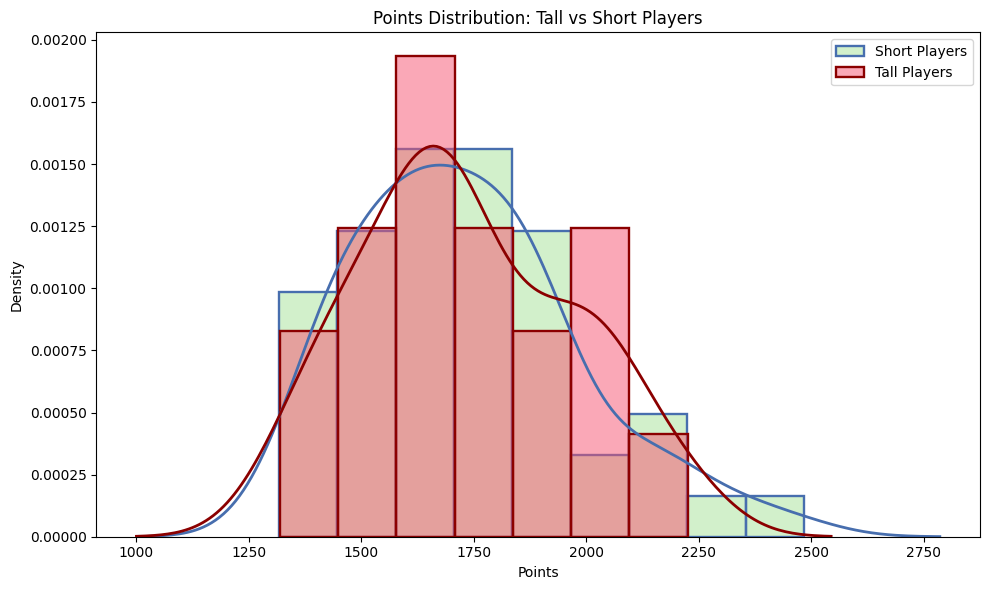

In [82]:
plt.figure(figsize=(10, 6))

sns.histplot(
    shorter_group['points'],
    color='#A7E399',
    edgecolor='#476EAE',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Short Players'
)
sns.kdeplot(
    shorter_group['points'],
    color='#476EAE',
    lw=2
)

sns.histplot(
    taller_group['points'],
    color='#F75270',
    edgecolor='#8B0000',
    linewidth=1.7,
    stat='density',
    alpha=0.5,
    label='Tall Players'
)
sns.kdeplot(
    taller_group['points'],
    color='#8B0000',
    lw=2
)

plt.title('Points Distribution: Tall vs Short Players')
plt.xlabel('Points')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
shorter_player_point = shorter_group['points']
taller_player_point = taller_group['points']

stat_past, p_value_past = shapiro(shorter_player_point)
print(f'Past Seasons: p-value = {p_value_past:.3f}')
if p_value_past > 0.05:
    print('Data is normal.')
else:
    print('Data is NOT normal.')

stat_recent, p_value_recent = shapiro(taller_player_point)
print(f'Recent Seasons: p-value = {p_value_recent:.3f}')
if p_value_recent > 0.05:
    print('Data is normal.')
else:
    print('Data is NOT normal.')

Past Seasons: p-value = 0.009
Data is NOT normal.
Recent Seasons: p-value = 0.150
Data is normal.


In [84]:
stat, p_value = mannwhitneyu(shorter_player_point, taller_player_point, alternative='two-sided')

print(f'Mann-Whitney U statistic: {stat:.3f}, \nP-value: {p_value:.3f}')

if p_value > 0.05:
    print('No significant difference → Fail to reject H₀')
else:
    print('Significant difference → Reject H₀')

Mann-Whitney U statistic: 2576.000, 
P-value: 0.829
No significant difference → Fail to reject H₀


<p dir="rtl">
میانگین امتیاز بازیکنانی که قد آن‌ها کمتر یا برابر با میانه بوده است برابر با 1733.404 و میانگین امتیاز بازیکنانی که قد آن‌ها بیشتر از میانه بوده است برابر با 1735.554 است. این دو مقدار بسیار نزدیک به هم هستند. 
<br><br>
آزمون آماری mannwhitneyu نیز نشان می‌دهد که این تفاوت از نظر آماری معنادار نیست (p-value = 0.829). 
<br><br>
بنابراین می‌توان گفت که اگرچه میانگین امتیاز بازیکنان قدبلند کمی بیشتر از بازیکنان قدکوتاه است، اما این اختلاف بر اساس آزمون آماری معنادار نبوده و فرض صفر رد نمی‌شود. 
</p>
